# Разработка модели для выявления рисков сердечного приступа на основании данных анализов и антропометрии пациентов.

## Цели исследования.

- Построить модель МО для выявления рисков возникновения сердечного приступа на основании полученных от пользователя данных.


- Выявление ключевых факторов риска влияющих на вероятность возникновения проблем с сердечно-сосудистой системой.


- Создание пользовательского интерфейса , на основании результатов полученных в ходе исследования.

## Ход исследования.

- Загрузка и первичное ознакомление с полученными данными.


- Анализ открытых медицинских данных, связанных с сердечно-сосудистыми заболеваниями, для оптимизации набора признаков: исключения нерелевантных и добавления новых переменных в исходный датасет.


- Анализ поступивших данных с целью выявления пропусков, аномалий и необходимости стандартизации представленных значений.


- Построение модели МО и оценка ее эффективности.


- Оформление финального вывода и переход к реализации модели через **FastApi**

## Полученная документация к поступившим данным.

- id  - id(Пациента)

- Антропометрические параметры (вес, возраст, рост)

- Привычки (курение, качество сна и т.д)

- Давление

- Наличие хронических заболеваний

- Биохимия крови

- Таргет - высокий или низкий риск поражения сердца


## Технический модуль.



### Импорт библиотек.

In [65]:
import sys
import os
sys.path.append("C:/Jupi/mast/src")

In [66]:
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
import time
import joblib
import math
from python.scripts import (find_binary,
                            graph_num,
                            check_data_dubmiss,
                            one_screen_hist)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import (r2_score, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             accuracy_score, precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Определение констант.


In [67]:
RS = 42 #random state 
#мэджик для отрисовки графиков сразу
%matplotlib inline 

## Загрузка и первичное ознакомление с данными.

### Загрузка датасетов.

In [68]:
df_test = pd.read_csv('heart_test.csv')
df_train = pd.read_csv('heart_train.csv')

### Ознакомление с данными

#### df_train

**Обработка названий признаков**

Для дальнейшего удобства , приведем названия столбцов к общепринятому формату сразу же на этом этапе.

In [69]:
df_train.columns = (df_train.columns.str.replace(r'[ -]', '_', regex=True).str.lower())

**Обзор полученных данных**

In [70]:
df_train.head(10)

unnamed:_0       age  cholesterol  heart_rate  diabetes  family_history  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   
3           3  0.730337     0.007143    0.053162       0.0             0.0   
4           4  0.775281     0.757143    0.021998       0.0             0.0   
5           5  0.168539     0.764286    0.057745       0.0             1.0   
6           6  0.483146     0.021429    0.036664       1.0             0.0   
7           7  0.235955     0.939286    0.081577       1.0             0.0   
8           8  0.685393     0.317857    0.039413       0.0             0.0   
9           9  0.213483     0.796429    0.076994       1.0             1.0   

   smoking  obesity  alcohol_consumption  exercise_hours_per_week  ...  \
0      1.0      1.0                  1.0                 0.535505  ...   
1      0.0      0.0                  1.0                 0.068690  ...   
2      1.0      1.0                  1.0                 0.944001  ...   
3      1.0      0.0                  1.0                 0.697023  ...   
4      1.0      0.0                  1.0                 0.412878  ...   
5      1.0      1.0                  1.0                 0.082682  ...   
6      1.0      0.0                  1.0                 0.540206  ...   
7      1.0      0.0                  1.0                 0.290837  ...   
8      1.0      0.0                  0.0                 0.803160  ...   
9      1.0      1.0                  0.0                 0.506971  ...   

   physical_activity_days_per_week  sleep_hours_per_day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   
5                              6.0             0.833333   
6                              5.0             0.000000   
7                              4.0             0.000000   
8                              6.0             0.166667   
9                              3.0             1.000000   

   heart_attack_risk_(binary)  blood_sugar     ck_mb  troponin  gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   
5                         0.0     0.227018  0.048229  0.036512    Male   
6                         1.0     0.231225  0.008940  0.000291    Male   
7                         0.0     0.227018  0.048229  0.036512    Male   
8                         1.0     0.126482  0.002332  0.007185    Male   
9                         0.0     0.227018  0.048229  0.036512    Male   

   systolic_blood_pressure  diastolic_blood_pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047  
5                 0.464516                  0.418605  5817  
6                 0.361290                  0.569767  5580  
7                 0.690323                  0.639535  4963  
8                 0.664516                  0.616279  4521  
9                 0.651613                  0.720930  2455  

[10 rows x 28 columns]

In [71]:
df_train.describe().T

count         mean          std  min  \
unnamed:_0                       8685.0  4342.000000  2507.287877  0.0   
age                              8685.0     0.449958     0.231174  0.0   
cholesterol                      8685.0     0.501070     0.284716  0.0   
heart_rate                       8685.0     0.050658     0.023453  0.0   
diabetes                         8442.0     0.652097     0.476333  0.0   
family_history                   8442.0     0.489576     0.499921  0.0   
smoking                          8442.0     0.902867     0.296157  0.0   
obesity                          8442.0     0.498342     0.500027  0.0   
alcohol_consumption              8442.0     0.601990     0.489517  0.0   
exercise_hours_per_week          8685.0     0.503378     0.284810  0.0   
diet                             8685.0     1.057455     0.866645  0.0   
previous_heart_problems          8442.0     0.495380     0.500008  0.0   
medication_use                   8442.0     0.501185     0.500028  0.0   
stress_level                     8442.0     5.493367     2.867862  1.0   
sedentary_hours_per_day          8685.0     0.499164     0.285340  0.0   
income                           8685.0     0.496055     0.284698  0.0   
bmi                              8685.0     0.496774     0.282561  0.0   
triglycerides                    8685.0     0.505484     0.286320  0.0   
physical_activity_days_per_week  8442.0     3.508292     2.281772  0.0   
sleep_hours_per_day              8685.0     0.503737     0.328061  0.0   
heart_attack_risk_(binary)       8685.0     0.346920     0.476017  0.0   
blood_sugar                      8685.0     0.227339     0.076635  0.0   
ck_mb                            8685.0     0.048159     0.075531  0.0   
troponin                         8685.0     0.036689     0.060157  0.0   
systolic_blood_pressure          8685.0     0.450295     0.170184  0.0   
diastolic_blood_pressure         8685.0     0.497634     0.171830  0.0   
id                               8685.0  4831.210823  2782.585625  1.0   

                                         25%          50%          75%     max  
unnamed:_0                       2171.000000  4342.000000  6513.000000  8684.0  
age                                 0.258427     0.460674     0.640449     1.0  
cholesterol                         0.267857     0.499780     0.746429     1.0  
heart_rate                          0.034830     0.050412     0.065995     1.0  
diabetes                            0.000000     1.000000     1.000000     1.0  
family_history                      0.000000     0.000000     1.000000     1.0  
smoking                             1.000000     1.000000     1.000000     1.0  
obesity                             0.000000     0.000000     1.000000     1.0  
alcohol_consumption                 0.000000     1.000000     1.000000     1.0  
exercise_hours_per_week             0.263286     0.502110     0.748709     1.0  
diet                                0.000000     1.000000     2.000000     3.0  
previous_heart_problems             0.000000     0.000000     1.000000     1.0  
medication_use                      0.000000     1.000000     1.000000     1.0  
stress_level                        3.000000     5.000000     8.000000    10.0  
sedentary_hours_per_day             0.255875     0.499920     0.744623     1.0  
income                              0.251922     0.494889     0.741036     1.0  
bmi                                 0.254190     0.494774     0.736974     1.0  
triglycerides                       0.263636     0.503603     0.750649     1.0  
physical_activity_days_per_week     2.000000     3.000000     6.000000     7.0  
sleep_hours_per_day                 0.166667     0.500000     0.833333     1.0  
heart_attack_risk_(binary)          0.000000     0.000000     1.000000     1.0  
blood_sugar                         0.227018     0.227018     0.227018     1.0  
ck_mb                               0.048229     0.048229     0.048229     1.0  
troponin         

In [72]:
ProfileReport(df_train, title="Profiling Report", minimal=True, progress_bar=False)

100%|██████████| 28/28 [00:00<00:00, 699.62it/s]


После анализа данных видно, что все переменные, кроме Gender, имеют числовой формат. Часть из них уже нормализована, часть представлена в исходном , а так же в бинарном виде.

##### Анализ не бинарных признаков.

Воспользуемся функцией по определению бинарных признаков.

In [73]:
bi = find_binary(df_train)
bi

['diabetes',
 'family_history',
 'smoking',
 'obesity',
 'alcohol_consumption',
 'previous_heart_problems',
 'medication_use',
 'heart_attack_risk_(binary)']

Исключим бинарные признаки из первичного анализа с целью определения способа стандартизации представленных данных.

In [74]:
df_train.drop([*bi, 'unnamed:_0'], axis=1).describe().T

count         mean          std  min  \
age                              8685.0     0.449958     0.231174  0.0   
cholesterol                      8685.0     0.501070     0.284716  0.0   
heart_rate                       8685.0     0.050658     0.023453  0.0   
exercise_hours_per_week          8685.0     0.503378     0.284810  0.0   
diet                             8685.0     1.057455     0.866645  0.0   
stress_level                     8442.0     5.493367     2.867862  1.0   
sedentary_hours_per_day          8685.0     0.499164     0.285340  0.0   
income                           8685.0     0.496055     0.284698  0.0   
bmi                              8685.0     0.496774     0.282561  0.0   
triglycerides                    8685.0     0.505484     0.286320  0.0   
physical_activity_days_per_week  8442.0     3.508292     2.281772  0.0   
sleep_hours_per_day              8685.0     0.503737     0.328061  0.0   
blood_sugar                      8685.0     0.227339     0.076635  0.0   
ck_mb                            8685.0     0.048159     0.075531  0.0   
troponin                         8685.0     0.036689     0.060157  0.0   
systolic_blood_pressure          8685.0     0.450295     0.170184  0.0   
diastolic_blood_pressure         8685.0     0.497634     0.171830  0.0   
id                               8685.0  4831.210823  2782.585625  1.0   

                                         25%          50%          75%     max  
age                                 0.258427     0.460674     0.640449     1.0  
cholesterol                         0.267857     0.499780     0.746429     1.0  
heart_rate                          0.034830     0.050412     0.065995     1.0  
exercise_hours_per_week             0.263286     0.502110     0.748709     1.0  
diet                                0.000000     1.000000     2.000000     3.0  
stress_level                        3.000000     5.000000     8.000000    10.0  
sedentary_hours_per_day             0.255875     0.499920     0.744623     1.0  
income                              0.251922     0.494889     0.741036     1.0  
bmi                                 0.254190     0.494774     0.736974     1.0  
triglycerides                       0.263636     0.503603     0.750649     1.0  
physical_activity_days_per_week     2.000000     3.000000     6.000000     7.0  
sleep_hours_per_day                 0.166667     0.500000     0.833333     1.0  
blood_sugar                         0.227018     0.227018     0.227018     1.0  
ck_mb                               0.048229     0.048229     0.048229     1.0  
troponin                            0.036512     0.036512     0.036512     1.0  
systolic_blood_pressure             0.303226     0.445161     0.600000     1.0  
diastolic_blood_pressure            0.348837     0.500000     0.651163     1.0  
id                               2425.000000  4837.000000  7242.000000  9650.0

Опираясь на то что обработанные данные легли в диапазоне от 0 до 1 , можем сделать вывод что был применен MinMaxScaler.

Возможно эта информация пригодится при обработке оставшихся необработанных числовых переменных на этапе предобработки данных.

#### df_test

**Обработка названий признаков**

Для дальнейшего удобства , приведем названия столбцов к общепринятому формату сразу же на этом этапе.

In [75]:
df_test.columns = (df_test.columns.str.replace(r'[ -]', '_', regex=True).str.lower())

**Обзор полученных данных**

In [76]:
df_test.head(10)

unnamed:_0       age  cholesterol  heart_rate  diabetes  family_history  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   
3           3  0.460674     0.567857    0.055912       1.0             1.0   
4           4  0.719101     0.485714    0.022915       1.0             0.0   
5           5  0.561798     0.792857    0.026581       1.0             1.0   
6           6  0.674157     0.853571    0.019248       1.0             1.0   
7           7  0.539326     0.335714    0.036664       1.0             1.0   
8           8  0.449438     0.328571    0.075160       1.0             0.0   
9           9  0.617978     0.728571    0.032081       0.0             1.0   

   smoking  obesity  alcohol_consumption  exercise_hours_per_week  ...  \
0      1.0      1.0                  1.0                 0.361618  ...   
1      0.0      1.0                  0.0                 0.996483  ...   
2      1.0      1.0                  0.0                 0.995561  ...   
3      1.0      1.0                  1.0                 0.437277  ...   
4      1.0      0.0                  1.0                 0.514920  ...   
5      1.0      1.0                  0.0                 0.774470  ...   
6      1.0      0.0                  1.0                 0.149123  ...   
7      1.0      0.0                  1.0                 0.329720  ...   
8      1.0      0.0                  0.0                 0.487405  ...   
9      1.0      0.0                  0.0                 0.211485  ...   

   triglycerides  physical_activity_days_per_week  sleep_hours_per_day  \
0       0.306494                              1.0             0.333333   
1       0.087013                              0.0             0.166667   
2       0.205195                              7.0             1.000000   
3       0.163636                              0.0             0.666667   
4       0.580519                              5.0             0.000000   
5       0.362338                              1.0             0.666667   
6       0.211688                              3.0             0.000000   
7       0.835065                              7.0             0.666667   
8       0.819481                              2.0             0.166667   
9       0.196104                              0.0             1.000000   

   blood_sugar     ck_mb  troponin  gender  systolic_blood_pressure  \
0     0.227018  0.048229  0.036512    Male                 0.283871   
1     0.227018  0.048229  0.036512  Female                 0.703226   
2     0.102767  0.002666  0.088455    Male                 0.458065   
3     0.203557  0.056390  0.271774  Female                 0.741935   
4     0.227018  0.048229  0.036512    Male                 0.412903   
5     0.227018  0.048229  0.036512    Male                 0.161290   
6     0.227018  0.048229  0.036512    Male                 0.535484   
7     0.695652  0.002466  0.000874    Male                 0.496774   
8     0.227018  0.048229  0.036512    Male                 0.677419   
9     0.227018  0.048229  0.036512    Male                 0.722581   

   diastolic_blood_pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825  
5                  0.593023  1076  
6                  0.546512  5020  
7                  0.662791  4267  
8                  0.430233  4003  
9                  0.255814  2519  

[10 rows x 27 columns]

In [77]:
df_test.describe().T

count         mean          std       min  \
unnamed:_0                       966.0   482.500000   279.004480  0.000000   
age                              966.0     0.452916     0.231068  0.044944   
cholesterol                      966.0     0.488181     0.282039  0.000000   
heart_rate                       966.0     0.051644     0.035502  0.000000   
diabetes                         935.0     0.656684     0.475070  0.000000   
family_history                   935.0     0.481283     0.499917  0.000000   
smoking                          935.0     0.898396     0.302289  0.000000   
obesity                          935.0     0.516578     0.499993  0.000000   
alcohol_consumption              935.0     0.583957     0.493165  0.000000   
exercise_hours_per_week          966.0     0.490706     0.284902  0.000336   
diet                             966.0     1.053830     0.884642  0.000000   
previous_heart_problems          935.0     0.494118     0.500233  0.000000   
medication_use                   935.0     0.488770     0.500141  0.000000   
stress_level                     935.0     5.332620     2.858466  1.000000   
sedentary_hours_per_day          966.0     0.506715     0.287826  0.001187   
income                           966.0     0.484408     0.273879  0.003351   
bmi                              966.0     0.476796     0.291987  0.002598   
triglycerides                    966.0     0.486688     0.284534  0.000000   
physical_activity_days_per_week  935.0     3.443850     2.302778  0.000000   
sleep_hours_per_day              966.0     0.512571     0.322292  0.000000   
blood_sugar                      966.0     0.224127     0.065270  0.029644   
ck_mb                            966.0     0.048855     0.079742  0.000000   
troponin                         966.0     0.034926     0.053855  0.000194   
systolic_blood_pressure          966.0     0.447172     0.171837  0.012903   
diastolic_blood_pressure         966.0     0.496822     0.173935  0.116279   
id                               966.0  4769.160455  2818.815407  0.000000   

                                         25%          50%          75%  \
unnamed:_0                        241.250000   482.500000   723.750000   
age                                 0.247191     0.460674     0.640449   
cholesterol                         0.243750     0.499780     0.710714   
heart_rate                          0.036664     0.050412     0.065995   
diabetes                            0.000000     1.000000     1.000000   
family_history                      0.000000     0.000000     1.000000   
smoking                             1.000000     1.000000     1.000000   
obesity                             0.000000     1.000000     1.000000   
alcohol_consumption                 0.000000     1.000000     1.000000   
exercise_hours_per_week             0.243431     0.502110     0.734425   
diet                                0.000000     1.000000     2.000000   
previous_heart_problems             0.000000     0.000000     1.000000   
medication_use                      0.000000     0.000000     1.000000   
stress_level                        3.000000     5.000000     8.000000   
sedentary_hours_per_day             0.258713     0.501327     0.759591   
income                              0.261446     0.492015     0.705371   
bmi                                 0.217527     0.471185     0.720503   
triglycerides                       0.249675     0.488961     0.718182   
physical_activity_days_per_week     1.000000     3.000000     5.000000   
sleep_hours_per_day                 0.166667     0.500000     0.833333   
blood_sugar                         0.227018     0.227018     0.227018   
ck_mb                               0.048229     0.048229     0.048229   
troponin                            0.036512     0.036512     0.036512   
systolic_blood_pressure             0.296774     0.445161     0.600000   
diastolic_blood_pressure            0.348837     0.488372     0.639535   
id

In [78]:
ProfileReport(df_test, title="Profiling Report", minimal=True, progress_bar=False)

100%|██████████| 27/27 [00:00<00:00, 3374.84it/s]


Набор данных **df_test** имеет схожую структуру данных с **df_train** , так как является тестовым набором данных для проверки модели. Все выводы сделанные при анализе **df_train** применимы и к **df_test**.


Тестовая как и тренировочная выборка обладает пропусками , стратегию по их заполнению мы определим после анализа медицинской специфики на этапе предобработки данных.

### Вывод

- После загрузки и первичного ознакомления можно сделать вывод, что присланные данные находятся в достаточно «сыром» виде для непосредственного использования в обучении модели: часть данных уже нормализована при помощи MinMaxScaler, часть данных находится в «чистом» виде, также присутствуют частые пропуски, выбросы и аномалии в данных.

- Улучшением качества датасетов , займемся в блоке предобработки , после более детального погружения в специфику данных.

## Анализ открытых источников.

### Анализ медицинской специфики связанной с нарушением сердечной деятельности.

Рассмотрим представленные признаки и попытаемся распределить их по группам на основании их важности в разрезе поставленной задачи.

In [79]:
df_train.columns

Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar',
       'ck_mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

Обратимся к открытым источникам что бы получить более развернутое описание каждого из признаков.

| **Признак**                      | **Описание** |
|-----------------------------------|--------------|
| - **age**                         | - Возраст пациента (в годах). |
| - **cholesterol**                 | - Уровень холестерина в крови (в мг/дл или ммоль/л). |
| - **heart_rate**                  | - Частота сердечных сокращений (уд./мин). |
| - **diabetes**                    | - Наличие диабета (бинарный признак: 1 – есть, 0 – нет). |
| - **family_history**              | - Наличие сердечных заболеваний у родственников (1 – есть, 0 – нет). |
| - **smoking**                     | - Статус курения (1 – курит, 0 – не курит). |
| - **obesity**                     | - Наличие ожирения (обычно определяется по ИМТ ≥ 30, 1 – есть, 0 – нет). |
| - **alcohol_consumption**         | - Уровень потребления алкоголя (например, граммы в неделю или категории). |
| - **exercise_hours_per_week**     | - Количество часов физических упражнений в неделю. |
| - **diet**                        | - Тип диеты (категориальный признак, представлен значениями : 0, 1, 2, 3). |
| - **previous_heart_problems**     | - Наличие перенесенных сердечных заболеваний (1 – да, 0 – нет). |
| - **medication_use**              | - Прием лекарств, связанных с сердечно-сосудистой системой (1 – да, 0 – нет). |
| - **stress_level**                | - Уровень стресса (шкала, например, от 1 до 10). |
| - **sedentary_hours_per_day**     | - Количество часов сидячего образа жизни в день. |
| - **income**                      | - Уровень дохода (категориальный или числовой, например, в долларах в год). |
| - **bmi**                         | - Индекс массы тела (кг/м²). |
| - **triglycerides**               | - Уровень триглицеридов в крови (в мг/дл или ммоль/л). |
| - **physical_activity_days_per_week** | - Количество дней в неделю с физической активностью. |
| - **sleep_hours_per_day**         | - Среднее количество часов сна в сутки. |
| - **heart_attack_risk_(binary)**  | - Целевая переменная: риск инфаркта (1 – высокий, 0 – низкий). |
| - **blood_sugar**                 | - Уровень глюкозы в крови (в мг/дл или ммоль/л). |
| - **ck_mb**                       | - Уровень креатинкиназы-MB (фермент, указывающий на повреждение сердца). |
| - **troponin**                    | - Уровень тропонина (биомаркер повреждения миокарда). |
| - **gender**                      | - Пол пациента (категориальный: "мужской", "женский" или бинарный 1/0). |
| - **systolic_blood_pressure**     | - Систолическое артериальное давление (мм рт. ст.). |
| - **diastolic_blood_pressure**    | - Диастолическое артериальное давление (мм рт. ст.). |

**Объединение признаков по группам по степени важности**

| Уровень важности       | Признаки                                                                 | Обоснование                                                                                     |
|-------------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| **Критически важные**   | troponin, ck_mb, previous_heart_problems,    | Прямые биомаркеры повреждения миокарда и ключевые клинические показатели                        |
|                         | systolic_blood_pressure, diastolic_blood_pressure                        |                                                                                                  |
| **Высокая важность**    | age, gender, cholesterol, diabetes, bmi, obesity, blood_sugar, triglycerides    | Основные медицинские факторы риска, подтвержденные исследованиями                               |
| **Средняя важность**    | family_history, smoking, stress_level, medication_use,                  | Значимые факторы, но с менее прямой корреляцией                                                 |
|                         | physical_activity_days_per_week                                          |                                                                                                  |
| **Условно значимые**    | diet, alcohol_consumption, sedentary_hours_per_day, sleep_hours_per_day, | Влияют опосредованно или в сочетании с другими факторами                                        |
|                         | heart_rate                                                               |                                                                                                  |
| **Слабая важность**     | income, exercise_hours_per_week                                  | Минимальное прямое влияние или требуют дополнительных данных                                    |

**Сравнительный анализ сервисов, выполняющих аналогичную задачу.**

В ходе анализа открытых источников медицинской тематики удалось обнаружить аналогичные попытки создания сервиса для прогнозирования риска возникновения сердечно-сосудистых заболеваний.

| Характеристика          | Framingham Risk Score (FRS)                           | ASCVD Risk Calculator                          | SCORE (Systematic COronary Risk Evaluation)     |
|-------------------------|------------------------------------------------------|-----------------------------------------------|------------------------------------------------|
| **Разработчик**         | Framingham Heart Study (NIH)                         | ACC/AHA (2013)                                | Европейское общество кардиологов (ESC)         |
| **Период валидации**    | 1960-2000-е                                          | Современные данные (после 2000)               | 2003 (актуальные версии SCORE2, SCORE2-OP, 2021) |
| **Основное назначение** | 10-летний риск коронарных событий                    | 10-летний риск атеросклеротических событий    | 10-летний риск смертельных ССЗ (ИБС, инсульт)  |
| **Входные параметры**  | • Возраст <br> • Пол <br> • Общий холестерин <br> • ЛПВП(антогонист triglycerides) <br> • Систолическое АД <br> • Курение <br> • Диабет | • Возраст <br> • Пол <br> • Раса <br> • Общий холестерин <br> • ЛПВП(антогонист triglycerides) <br> • Систолическое АД <br> • Лечение гипертонии <br> • Курение <br> • Диабет | • Возраст <br> • Пол <br> • Систолическое АД <br> • Курение <br> • Общий холестерин <br> • **Страна проживания** (риск-регион) |
| **Оцениваемые исходы**  | • ИМС <br> • Смерть от ИБС <br> • Инсульт            | • Инфаркт <br> • Инсульт <br> • ОКС           | • Смерть от ИБС <br> • Смерть от инсульта <br> • Фатальные ССЗ |
| **Шкала риска**         | Низкий (<10%), Средний (10-20%), Высокий (>20%)      | Низкий (<5%), Пограничный (5-7.5%), Высокий (>7.5%) | Низкий (<1%), Умеренный (1-5%), Высокий (5-10%), Очень высокий (>10%) |
| **Клиническое применение** | • Первичная профилактика                          | • Рекомендации по статинам                     | • Европейские рекомендации ESC <br> • Выделение групп для агрессивной профилактики |
| **Ограничения**         | Не учитывает расу, ожирение, семейный анамнез        | Переоценка риска у некоторых этнических групп | Не оценивает нефатальные события               |
| **Онлайн-доступ**       | [Framingham Calculator](https://www.framinghamheartstudy.org/) | [ACC ASCVD Calculator](https://tools.acc.org/ASCVD-Risk-Estimator/) | [ESC SCORE2](https://www.escardio.org/Education/ESC-Prevention-of-CVD-Programme/Risk-calculation) |


Расшифровка к аббревиатурам

| Сокращение | Расшифровка                                                                 |
|------------|-----------------------------------------------------------------------------|
| **ИМС**    | Ишемическая болезнь сердца (в контексте FRS – включает инфаркт, стенокардию) |
| **ИБС**    | Ишемическая болезнь сердца                                                  |
| **ОКС**    | Острый коронарный синдром (включает инфаркт и нестабильную стенокардию)     |
| **ССЗ**    | Сердечно-сосудистые заболевания                                             |
| **ЛПВП**   | Липопротеины высокой плотности ("хороший" холестерин)                       |
| **АД**     | Артериальное давление                                                       |
| **ИМпST**  | Инфаркт миокарда с подъемом сегмента ST (острая форма ИБС)                  |
| **КФК-МБ** | Креатинфосфокиназа-МВ (фермент, маркер повреждения миокарда)                |

Общие признаки которые сервисы принимают на вход

| Признак                     | Framingham Risk Score (FRS) | ASCVD Risk Calculator | SCORE | Примечания |
|-----------------------------|----------------------------|-----------------------|-------|------------|
| **Возраст**                 | ✅                         | ✅                   | ✅    | Основной фактор риска |
| **Пол**                     | ✅                         | ✅                   | ✅    | Мужской пол - более высокий риск |
| **Общий холестерин**        | ✅                         | ✅                   | ✅    | Учитывается во всех моделях |
| **ЛПВП(антогонист triglycerides)**                    | ✅                         | ✅                   | ❌    | SCORE не использует напрямую |
| **Систолическое АД**        | ✅                         | ✅                   | ✅    | Ключевой параметр |
| **Курение**                 | ✅                         | ✅                   | ✅    | Важный модифицируемый фактор |
| **Диабет**                  | ✅                         | ✅                   | ❌    | SCORE учитывает опосредованно через другие параметры |
| **Лечение гипертонии**      | ❌                         | ✅                   | ❌    | Только в ASCVD |
| **Раса/этническая группа**  | ❌                         | ✅                   | ❌    | Только в ASCVD |
| **Страна проживания**       | ❌                         | ❌                   | ✅    | Уникальный параметр SCORE |

Проанализировав медицинскую сферу и аналогичные представленные на рынке продукты. Приходим к выводу что основными признаками могут выступать **troponin, ck_mb, systolic_blood_pressure, diastolic_blood_pressure , age, gender, cholesterol, diabetes, bmi, obesity, blood_sugar, triglycerides , family_history, smoking.**       

**Разделение признаков на объективные и субъективные**

Так же для удобства разделим представленные признаки на две группы *объективные(измеримые)* и *субъективные(заполняются пользователем по ощущениям)*

Для лучшей работы сервиса лучше использовать измеримые показатели , так как зачастую пользователи склонны к самообману и завышению опросных показателей.


| Тип признака       | Признак                          | Характеристика измерения          |
|--------------------|----------------------------------|-----------------------------------|
| **Объективные**    | age                              | Фиксируемый параметр              |
|                    | cholesterol                      | Лабораторный анализ               |
|                    | heart_rate                       | Измерение прибором                |
|                    | diabetes                         | Диагностика по анализам           |
|                    | bmi                              | Расчёт по антропометрическим данным (Измеримый аналог obesity)|
|                    | triglycerides                    | Лабораторный анализ               |
|                    | blood_sugar                      | Анализ крови                      |
|                    | ck_mb                            | Анализ крови (кардиомаркер)       |
|                    | troponin                         | Анализ крови (маркер инфаркта)    |
|                    | systolic_blood_pressure          | Измерение тонометром              |
|                    | diastolic_blood_pressure         | Измерение тонометром              |
|                    | sleep_hours_per_day              | Данные с трекера                  |
| **Субъективные**   | family_history                   | Опрос пациента                    |
|                    | smoking                          | Самоотчёт                         |
|                    | obesity                          | Самооценка                        |
|                    | alcohol_consumption              | Самоотчёт                         |
|                    | exercise_hours_per_week          | Приблизительная оценка            |
|                    | diet                             | Опросный метод                    |
|                    | previous_heart_problems          | Со слов пациента                  |
|                    | medication_use                   | Самоотчёт                         |
|                    | stress_level                     | Субъективная шкала                |
|                    | sedentary_hours_per_day          | Оценка образа жизни               |
|                    | income                           | Самоотчёт                         |
|                    | physical_activity_days_per_week  | Самооценка                        |                    

**Условные обозначения:**
- • Объективные: медицинские измерения и приборные данные
- • Субъективные: опросные данные и самоотчёты

### Анализ взаимосвязи количества полей для заполнения в приложении с конечной конверсией пользователей.

| Source                                  | Key Finding                                                                 | Link                                                                 |
|-----------------------------------------|-----------------------------------------------------------------------------|----------------------------------------------------------------------|
| **Venture Harbour**                     | Analyzes how form length directly impacts conversion rates.                 | [Link](https://ventureharbour.com/how-form-length-impacts-conversion-rates/) |
| **Medium (Ramin Zamani)**               | Explores optimal number of form fields for balance between data and conversions. | [Link](https://medium.com/@raminzamani/how-many-fields-should-you-have-on-a-form-4a3447661209) |
| **DashClicks**                          | Rule of thumb: 3–5 fields max; more fields reduce conversions.              | [Link](https://www.dashclicks.com/blog/form-fields-and-conversion-rates#:~:text=The%20general%20rule%20of%20thumb,process%2C%20thereby%20reducing%20conversion%20rates.) |
| **Activity Messenger**                  | Unbounce study: Reducing fields from 11 to 4 increased conversions by 120%.  | [Link](https://activitymessenger.com/blog/11-simple-changes-that-will-skyrocket-your-registration-form-conversions/#:~:text=In%20fact%2C%20a%20study%20by%20Unbounce%20found,resulted%20in%20a%20120%25%20increase%20in%20conversions.) |

Согласно исследованиям, доступным в открытых источниках, избыточное количество заполняемых полей может негативно влиять на вовлеченность пользователей.

Поскольку наша ключевая задача — развертывание удобного сервиса для конечных пользователей, этот фактор необходимо учитывать при выборе числа признаков для обучения модели. В текущей тренировочной выборке присутствует 24 признака, что является избыточным. Для оптимизации модели следует провести корреляционный и мультиколлинеарный анализ, чтобы исключить второстепенные и дублирующие признаки и сократить их количество до 7–10 ключевых.

#### Вывод (Старый)
- Так как основной задачей является построение сервиса для оценки рисков проблем с сердцем , то было решено отобрать несколько параметров что бы не перегружать интерфейс и не вызывать недовольство пользователей. 

- На основании проведенного обзора открытых источников предлагается отобрать 7-10 *измеримых* признаков для обучения модели и оформления интерфейса в приложении.

- Окончательный набор признаков будет определен после предобработки данных и проведения корреляционного и мультиколлинеарного анализа.

### Вывод (Новый)

- Так как большинство признаков уже обработаны *скейлером* , а изначальный масштаб признаков нам не известем и обратная декомпиляция не возможна.

- Сосредоточимся на создании сервиса где на вход будем передавать подготовленную тестовую выборку для предсказания целевого признака.

## Корреляционный анализ

Посмотрим на корреляцию признаков с таргетом перед обработкой признаков.

### phik

interval columns not set, guessing: ['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar', 'ck_mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']


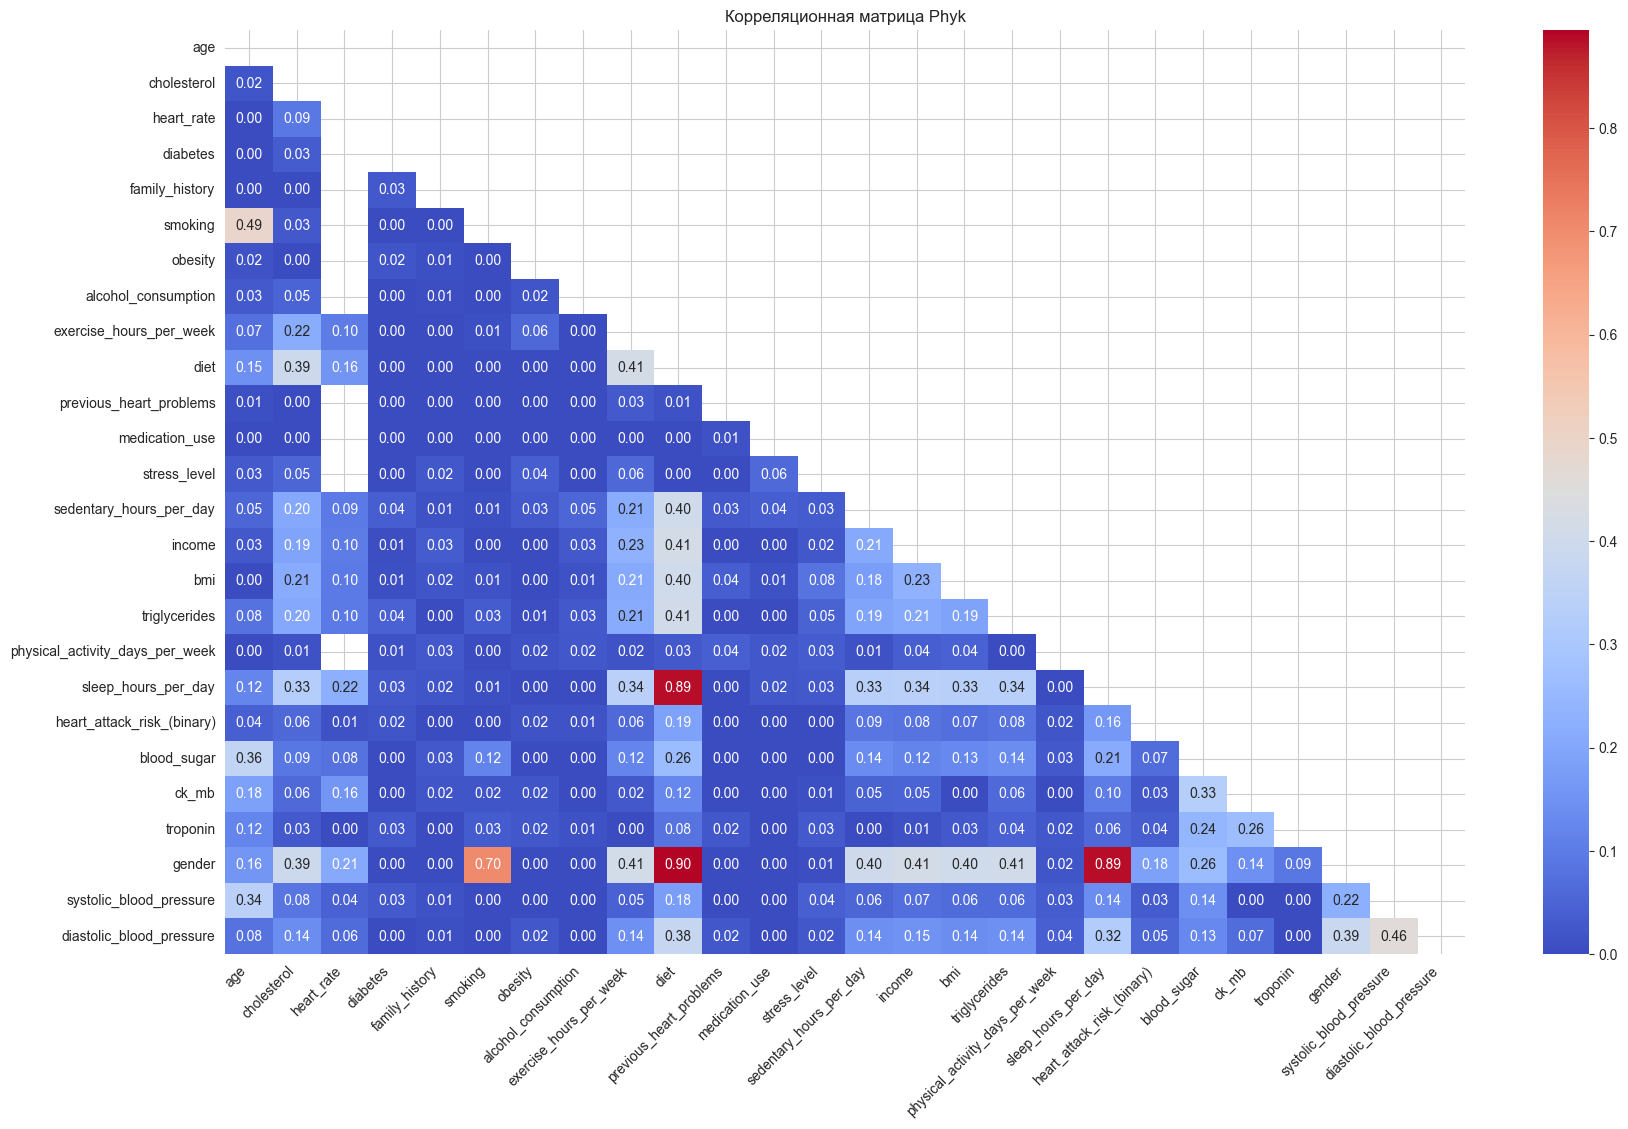

In [80]:
phik_matrix = df_train.drop(['id', 'unnamed:_0'], axis=1).phik_matrix()
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(20, 12))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

### spearman

In [81]:
num_col = df_train.drop(['id', 'unnamed:_0'], axis=1).select_dtypes(include=['int64', 'float64']).columns
num_col

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history',
       'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'blood_sugar', 'ck_mb', 'troponin',
       'systolic_blood_pressure', 'diastolic_blood_pressure'],
      dtype='object')

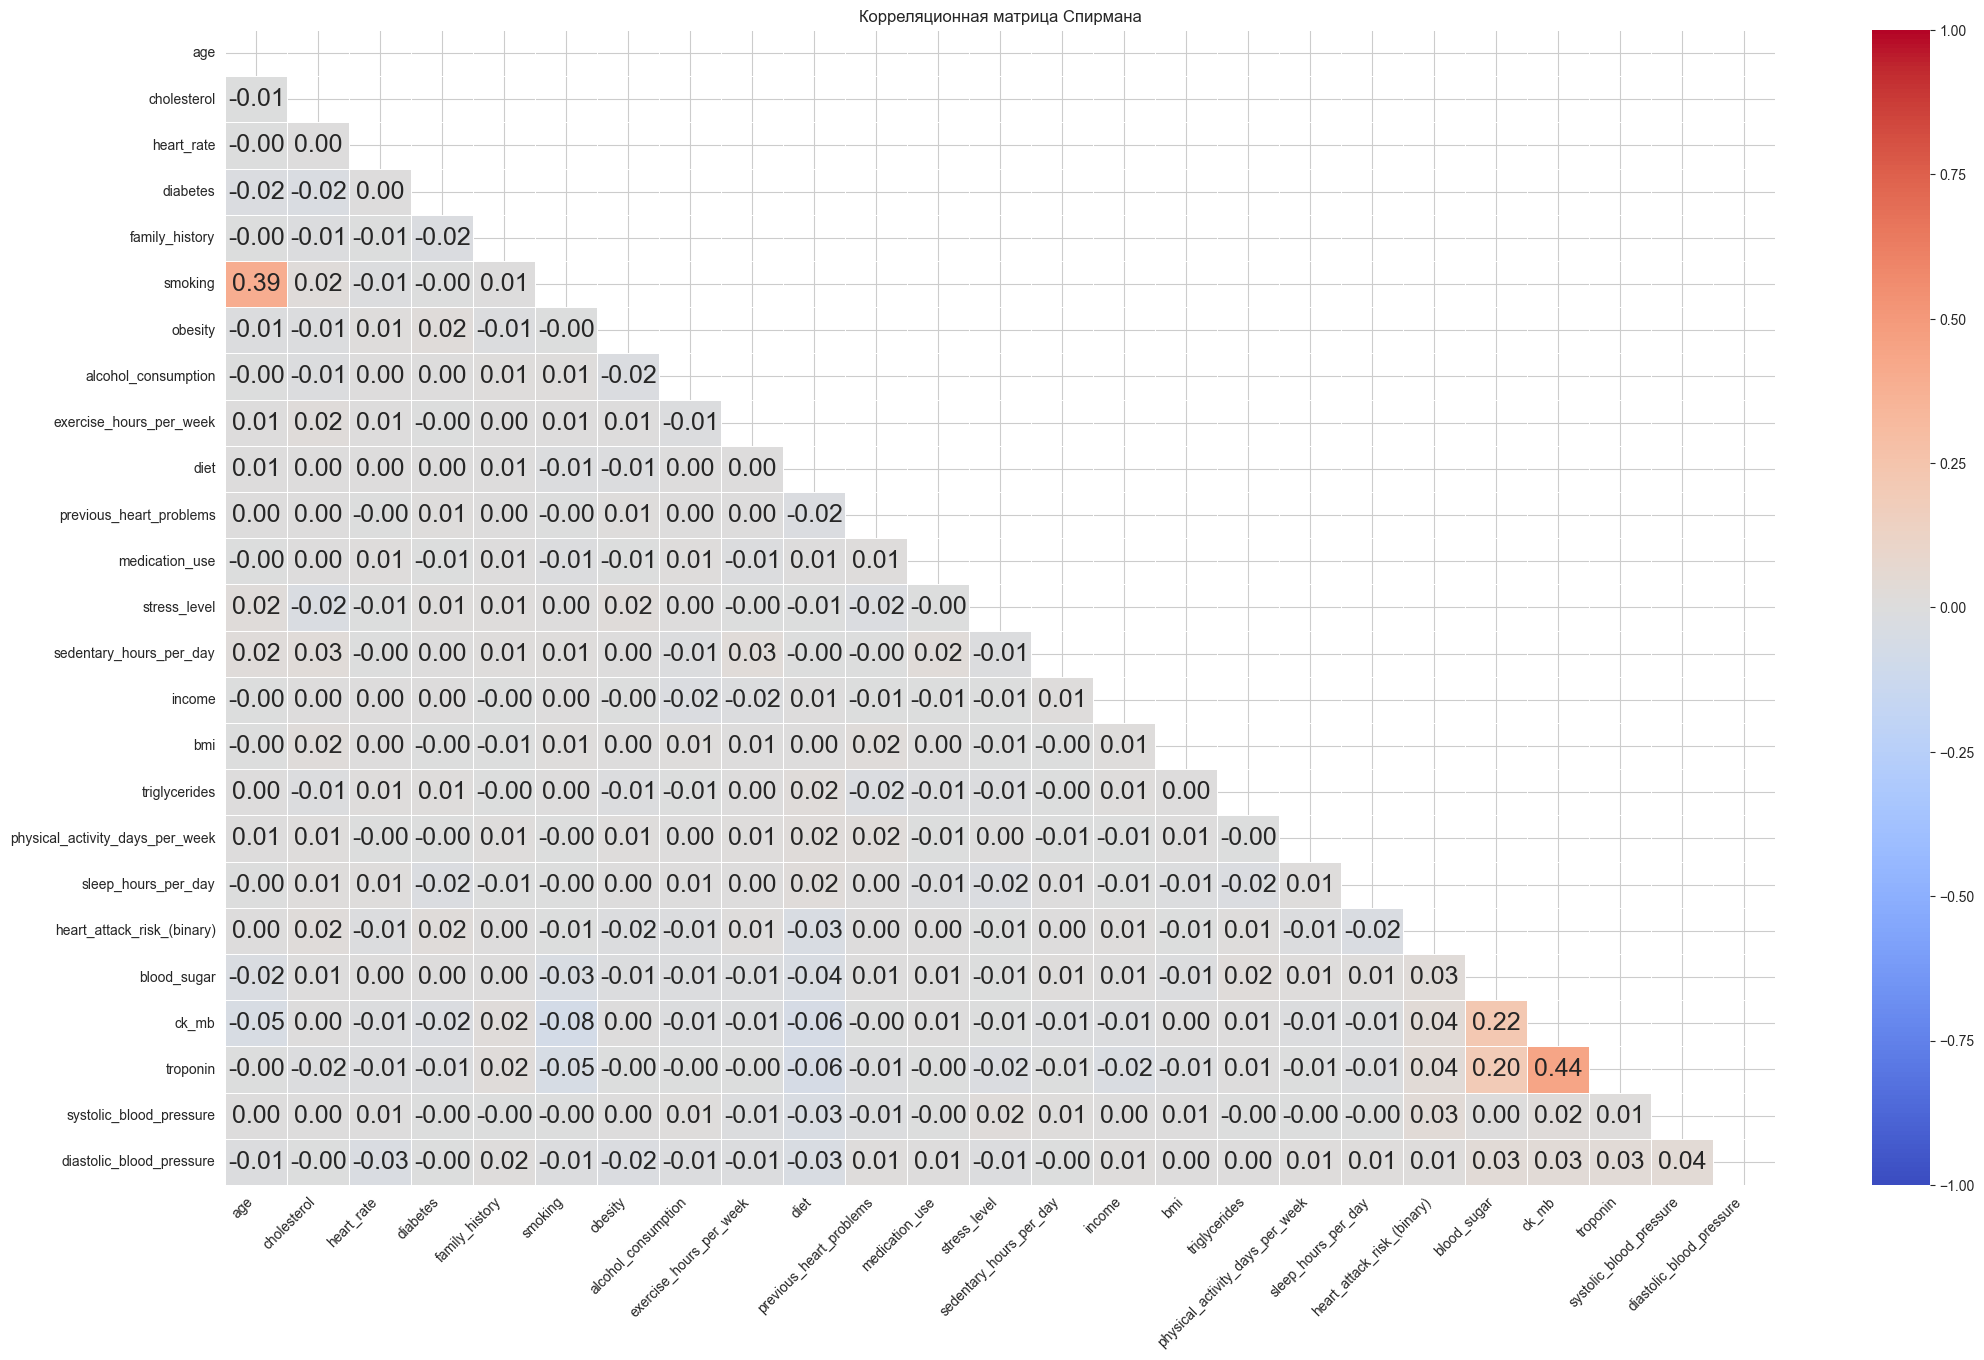

In [82]:
tri = np.triu(np.ones_like(df_train[num_col].corr(), dtype=bool))
plt.figure(figsize=(25, 15))
heatmap = sns.heatmap(
    df_train[num_col].corr('spearman'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Спирмана")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

### pearson

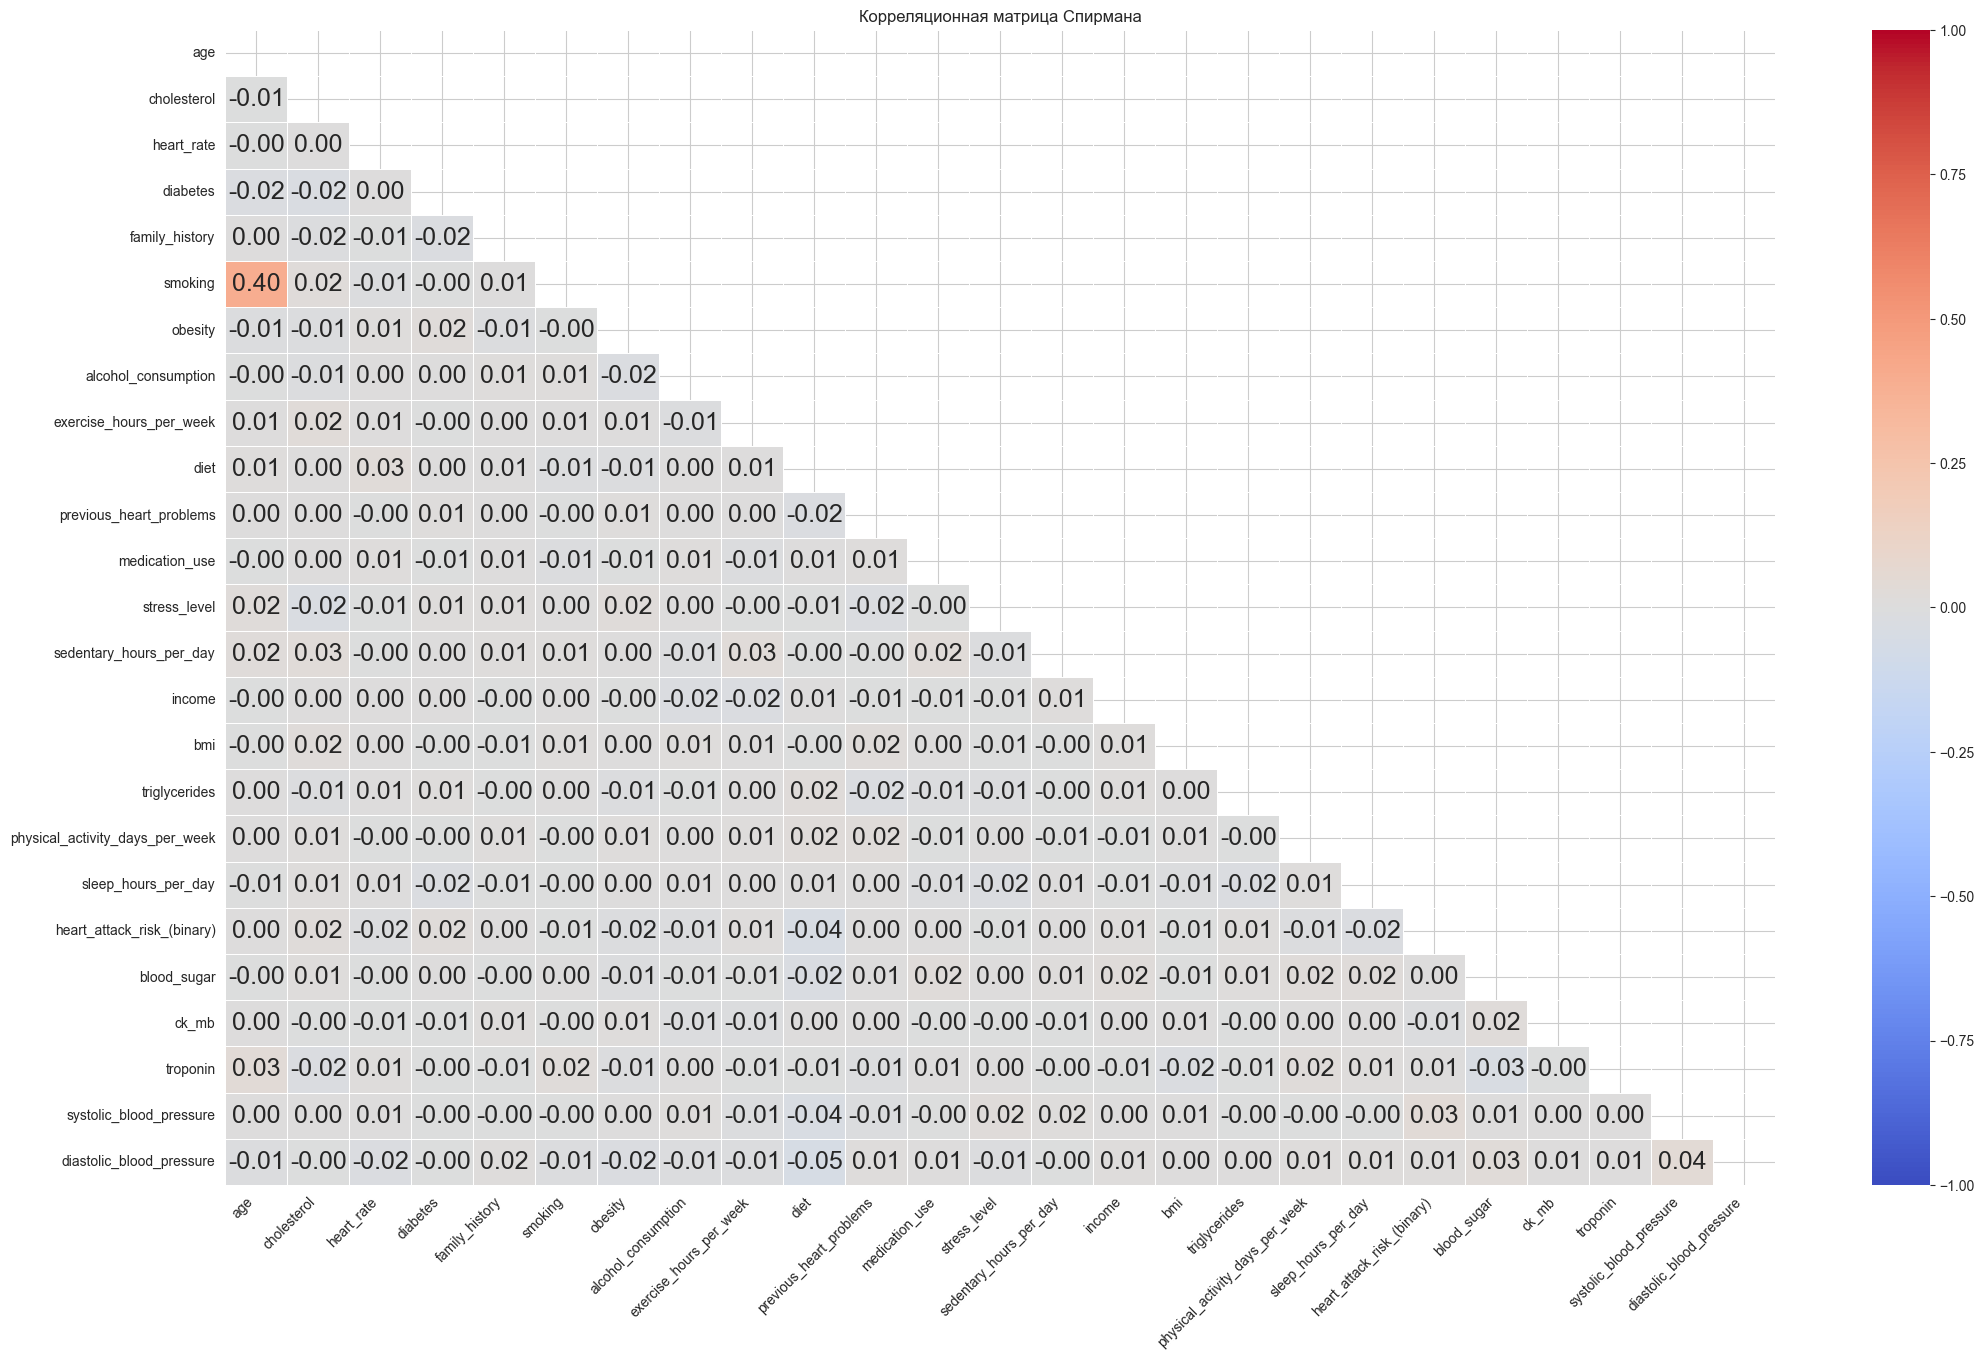

In [83]:
tri = np.triu(np.ones_like(df_train[num_col].corr(), dtype=bool))
plt.figure(figsize=(25, 15))
heatmap = sns.heatmap(
    df_train[num_col].corr('pearson'), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,  
    vmin=-1, vmax=1, annot_kws={"size": 18}, mask=tri)     
plt.title("Корреляционная матрица Спирмана")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.show()

При применении разных методов оценки корреляции.

Сильной корреляции какого либо признака с таргетом не обнаружилось , возможно это вызвано тем что часть признаков не нормализована.

## Предобработка данных

### Обработка явных дефектов и аномалий.

#### unnamed:_0

Первоначально удалим столбец *unnamed:_0* который дублирует индексацию строк реализованную в *pandas*.

In [84]:
df_train = df_train.drop(['unnamed:_0'], axis=1)
df_train.columns

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history',
       'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'blood_sugar', 'ck_mb', 'troponin',
       'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

In [85]:
df_test = df_test.drop(['unnamed:_0'], axis=1)
df_train.columns

Index(['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history',
       'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week',
       'diet', 'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'blood_sugar', 'ck_mb', 'troponin',
       'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

#### heart_rate

На этапе первичного ознакомления с данными в этой переменной было замечено странное распределение значений.

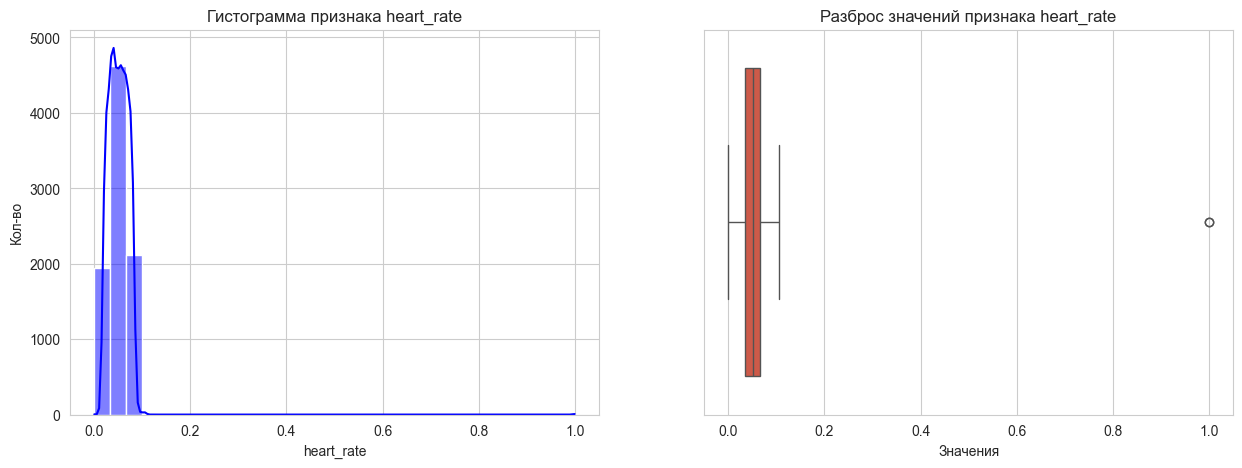

In [86]:
graph_num(df_train, 'heart_rate', 'heart_rate', 'heart_rate', bins=30)

In [87]:
df_train[df_train.heart_rate > 0.2]

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
1377  0.629213      0.49978         1.0       NaN             NaN      NaN   
2712  0.202247      0.49978         1.0       NaN             NaN      NaN   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  ...  \
1377      NaN                  NaN                  0.50211     3  ...   
2712      NaN                  NaN                  0.50211     3  ...   

      physical_activity_days_per_week  sleep_hours_per_day  \
1377                              NaN             0.504621   
2712                              NaN             0.504621   

      heart_attack_risk_(binary)  blood_sugar     ck_mb  troponin  gender  \
1377                         0.0     0.203557  0.011843  0.002622     0.0   
2712                         0.0     0.092885  0.007805  0.000680     0.0   

      systolic_blood_pressure  diastolic_blood_pressure    id  
1377                 0.490323                  0.616279  9547  
2712                 0.490323                  0.616279  9611  

[2 rows x 27 columns]

Видим что в переменной присутствуют значительные выбросы , учитывая ранее сделанное предположение о том что данные уже обработаны MinMaxScaler'om.

Наличие аномальных значений в момент кодировки переменной , влияет на масштаб остальных данных что в свою очередь делает их абсолютно не информативными и не пригодными для обучения модели.

Так же опираясь на изученные медицинские данные , частота пульса замеренная в лабораторных условиях(в спокойном состоянии) , малоинформативна для нашей задачи.

Принимаем решение об удалении этого столбца из наших датасетов.

In [88]:
df_train = df_train.drop(['heart_rate'], axis=1)
df_test = df_test.drop(['heart_rate'], axis=1)
df_train.columns , df_test.columns

(Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
        'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet',
        'previous_heart_problems', 'medication_use', 'stress_level',
        'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
        'physical_activity_days_per_week', 'sleep_hours_per_day',
        'heart_attack_risk_(binary)', 'blood_sugar', 'ck_mb', 'troponin',
        'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
       dtype='object'),
 Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
        'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet',
        'previous_heart_problems', 'medication_use', 'stress_level',
        'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
        'physical_activity_days_per_week', 'sleep_hours_per_day', 'blood_sugar',
        'ck_mb', 'troponin', 'gender', 'systolic_blood_pressure',
        'diastolic_blood_pressure', '

#### gender

На этапе *загрузки и ознакомления* с данными была замечена аномалия в переменной **gender** , начнем процесс улучшения нашего датасета с исправления этого признака.

In [89]:
df_train['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

Как видим в бинарном признаке *gender* 4 уникальных значения , что является либо ошибкой при выгрузке или же попыткой применения *энкодера* к изначально бинарному признаку.

Изучим подробней записи с значениями *'1.0', '0.0'*

In [90]:
susp = df_train[(df_train['gender'] == '1.0') | (df_train['gender'] == '0.0')]
susp.head(10)

age  cholesterol  diabetes  family_history  smoking  obesity  \
16   0.449438      0.49978       NaN             NaN      NaN      NaN   
90   0.370787      0.49978       NaN             NaN      NaN      NaN   
92   0.629213      0.49978       NaN             NaN      NaN      NaN   
185  0.516854      0.49978       NaN             NaN      NaN      NaN   
188  0.269663      0.49978       NaN             NaN      NaN      NaN   
204  0.674157      0.49978       NaN             NaN      NaN      NaN   
247  0.629213      0.49978       NaN             NaN      NaN      NaN   
392  0.370787      0.49978       NaN             NaN      NaN      NaN   
415  0.415730      0.49978       NaN             NaN      NaN      NaN   
416  0.404494      0.49978       NaN             NaN      NaN      NaN   

     alcohol_consumption  exercise_hours_per_week  diet  \
16                   NaN                  0.50211     3   
90                   NaN                  0.50211     3   
92                   NaN                  0.50211     3   
185                  NaN                  0.50211     3   
188                  NaN                  0.50211     3   
204                  NaN                  0.50211     3   
247                  NaN                  0.50211     3   
392                  NaN                  0.50211     3   
415                  NaN                  0.50211     3   
416                  NaN                  0.50211     3   

     previous_heart_problems  ...  physical_activity_days_per_week  \
16                       NaN  ...                              NaN   
90                       NaN  ...                              NaN   
92                       NaN  ...                              NaN   
185                      NaN  ...                              NaN   
188                      NaN  ...                              NaN   
204                      NaN  ...                              NaN   
247                      NaN  ...                              NaN   
392                      NaN  ...                              NaN   
415                      NaN  ...                              NaN   
416                      NaN  ...                              NaN   

     sleep_hours_per_day  heart_attack_risk_(binary)  blood_sugar     ck_mb  \
16              0.504621                         0.0     0.233202  0.026692   
90              0.504621                         0.0     0.154150  0.004702   
92              0.504621                         0.0     0.256917  0.012310   
185             0.504621                         0.0     0.559289  0.006704   
188             0.504621                         0.0     0.112648  0.051218   
204             0.504621                         0.0     0.120553  0.002299   
247             0.504621                         0.0     0.150198  0.002933   
392             0.504621                         0.0     0.197628  0.119858   
415             0.504621                         0.0     0.140316  0.004435   
416             0.504621                         0.0     0.193676  0.009540   

     troponin  gender  systolic_blood_pressure  diastolic_blood_pressure    id  
16   0.000777     1.0                 0.393548                  0.255814  9528  
90   0.042043     1.0                 0.258065                  0.337209  9640  
92   0.000777     0.0                 0.258065                  0.232558  9515  
185  0.000291     0.0                 0.174194                  0.151163  9491  
188  0.000485     0.0                 0.225806                  0.162791  9448  
204  0.003010     1.0                 0.167742                  0.162791  9594  
247  0.133896     1.0                 0.677419                  0.720930  9570  
392  0.025439     1.0                 0.258065                  0.453488  9649  
415  0.001748     1.0                 0.470968                  0.593023  9625  
416  0.034275     1.0                 0.387097                  0.372093  9574  

[10 rows x 2

In [91]:
ProfileReport(susp, title="Profiling Report", minimal=True, progress_bar=False)

100%|██████████| 26/26 [00:00<?, ?it/s]


При более детальном рассмотрении отчета, мы заметили идентичные значения в следующих признаках **cholesterol, exercise_hours_per_week, sedentary_hours_per_day, income, bmi, triglycerides, sleep_hours_per_day**, что точно является аномалией и указывает на ошибку при выгрузке данных.

Посмотрим так же на совпадения пропусков в изначальном датасете **df_train** и сделанным нами срезе по параметру *gender*.

In [92]:
miss = pd.concat([df_train.isna().sum().rename('df_train'),
                  susp.isna().sum().rename('susp')], axis=1)
miss

df_train  susp
age                                     0     0
cholesterol                             0     0
diabetes                              243   243
family_history                        243   243
smoking                               243   243
obesity                               243   243
alcohol_consumption                   243   243
exercise_hours_per_week                 0     0
diet                                    0     0
previous_heart_problems               243   243
medication_use                        243   243
stress_level                          243   243
sedentary_hours_per_day                 0     0
income                                  0     0
bmi                                     0     0
triglycerides                           0     0
physical_activity_days_per_week       243   243
sleep_hours_per_day                     0     0
heart_attack_risk_(binary)              0     0
blood_sugar                             0     0
ck_mb                                   0     0
troponin                                0     0
gender                                  0     0
systolic_blood_pressure                 0     0
diastolic_blood_pressure                0     0
id                                      0     0

Видим полное совпадение пропущенных значений.

Посмотрим на процентное соотношение количества строк нашего среза *miss* относительно нашего изначального датафрейма *df_train*.

In [93]:
print(f'Объем среза miss : {((len(susp) / len(df_train)) * 100).__round__(2)}%')

Объем среза miss : 2.8%


Опираясь на невозможность точного определения что стоит за значениями **1.0 и 0.0** , а также тот факт, что все пропуски в данных коррелируют с этими значениями и составляют лишь 2.8% от общего объёма, наиболее обоснованным решением представляется исключение данного среза из датасета.

In [94]:
ref = df_train.copy()
print(f'Изначальное кол-во строк: {len(ref)}')
df_train = df_train.drop(susp.index)
print(f'Кол-во строк после удаления: {len(df_train)}')


Изначальное кол-во строк: 8685
Кол-во строк после удаления: 8442


Сделаем тоже самое для тестовой выборки.

In [95]:
suspt = df_test[(df_test['gender'] == '1.0') | (df_test['gender'] == '0.0')]
suspt

age  cholesterol  diabetes  family_history  smoking  obesity  \
27   0.370787      0.49978       NaN             NaN      NaN      NaN   
37   0.573034      0.49978       NaN             NaN      NaN      NaN   
58   0.516854      0.49978       NaN             NaN      NaN      NaN   
60   0.370787      0.49978       NaN             NaN      NaN      NaN   
61   0.483146      0.49978       NaN             NaN      NaN      NaN   
156  0.516854      0.49978       NaN             NaN      NaN      NaN   
208  0.449438      0.49978       NaN             NaN      NaN      NaN   
235  0.325843      0.49978       NaN             NaN      NaN      NaN   
265  0.471910      0.49978       NaN             NaN      NaN      NaN   
339  0.348315      0.49978       NaN             NaN      NaN      NaN   
352  0.606742      0.49978       NaN             NaN      NaN      NaN   
397  0.629213      0.49978       NaN             NaN      NaN      NaN   
423  0.584270      0.49978       NaN             NaN      NaN      NaN   
456  0.348315      0.49978       NaN             NaN      NaN      NaN   
475  0.280899      0.49978       NaN             NaN      NaN      NaN   
484  0.617978      0.49978       NaN             NaN      NaN      NaN   
555  0.325843      0.49978       NaN             NaN      NaN      NaN   
563  0.516854      0.49978       NaN             NaN      NaN      NaN   
602  0.629213      0.49978       NaN             NaN      NaN      NaN   
631  0.573034      0.49978       NaN             NaN      NaN      NaN   
634  0.303371      0.49978       NaN             NaN      NaN      NaN   
651  0.348315      0.49978       NaN             NaN      NaN      NaN   
699  0.314607      0.49978       NaN             NaN      NaN      NaN   
731  0.438202      0.49978       NaN             NaN      NaN      NaN   
758  0.550562      0.49978       NaN             NaN      NaN      NaN   
771  0.606742      0.49978       NaN             NaN      NaN      NaN   
817  0.438202      0.49978       NaN             NaN      NaN      NaN   
826  0.426966      0.49978       NaN             NaN      NaN      NaN   
838  0.629213      0.49978       NaN             NaN      NaN      NaN   
920  0.651685      0.49978       NaN             NaN      NaN      NaN   
921  0.550562      0.49978       NaN             NaN      NaN      NaN   

     alcohol_consumption  exercise_hours_per_week  diet  \
27                   NaN                  0.50211     3   
37                   NaN                  0.50211     3   
58                   NaN                  0.50211     3   
60                   NaN                  0.50211     3   
61                   NaN                  0.50211     3   
156                  NaN                  0.50211     3   
208                  NaN                  0.50211     3   
235                  NaN                  0.50211     3   
265                  NaN                  0.50211     3   
339                  NaN                  0.50211     3   
352                  NaN                  0.50211     3   
397                  NaN                  0.50211     3   
423                  NaN                  0.50211     3   
456                  NaN                  0.50211     3   
475                  NaN                  0.50211     3   
484                  NaN                  0.50211     3   
555                  NaN                  0.50211     3   
563                  NaN                  0.50211     3   
602                  NaN                  0.50211     3   
631                  NaN                  0.50211     3   
634                  NaN                  0.50211     3   
651                  NaN                  0.50211     3   
699                  NaN                  0.50211     3   
731                  NaN                  0.50211     3   
758                  NaN                  0.50211     3   
771                  NaN                  0.50211     3   
817                  NaN                  0.5021

In [96]:
reft = df_test.copy()
print(f'Изначальное кол-во строк: {len(reft)}')
df_test = df_test.drop(suspt.index)
print(f'Кол-во строк после удаления: {len(df_test)}')


Изначальное кол-во строк: 966
Кол-во строк после удаления: 935


#### Аномальные значения в признаках **blood_sugar, ck_mb, troponin**

Из отчета на этапе *загрузки и ознакомления* , мы заметили аномалии в распределении значений.

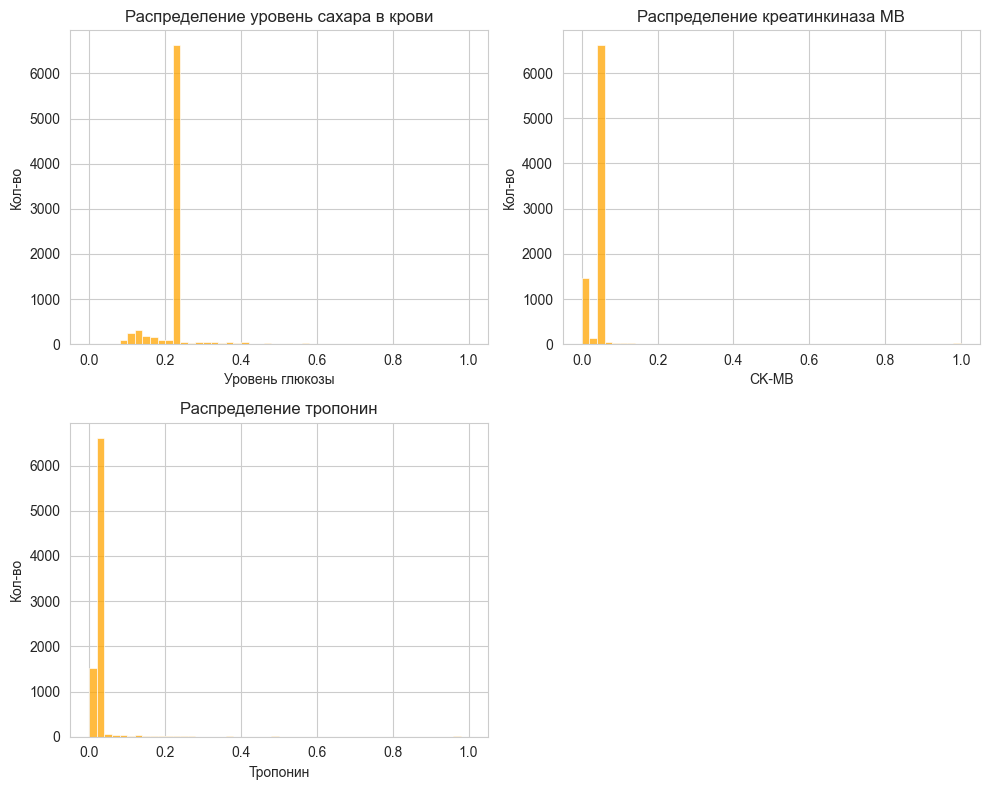

In [97]:
one_screen_hist(
    data=df_train,
    columns=[ 'blood_sugar', 'ck_mb', 'troponin'],
    titles=['уровень сахара в крови', 'креатинкиназа MB', 'тропонин'],
    xlabels=['Уровень глюкозы', 'CK-MB', 'Тропонин'],
    bins=50,
    color='orange',
    kde=False,
    title_prefix='Распределение '
)

Посмотрим на количественное распределение уникальных значений.

In [98]:
result = pd.concat([df_train['blood_sugar'].value_counts().head(10).rename_axis('blood_sugar_value').reset_index(name='blood_sugar_count'), 
                    df_train['ck_mb'].value_counts().head(10).rename_axis('ck_mb_value').reset_index(name='ck_mb_count'), 
                    df_train['troponin'].value_counts().head(10).rename_axis('troponin_value').reset_index(name='troponin_count')], axis=1)

result.head(10)

blood_sugar_value  blood_sugar_count  ck_mb_value  ck_mb_count  \
0           0.227018               6551     0.048229         6551   
1           0.128458                 52     1.000000           25   
2           0.102767                 52     0.005970           16   
3           0.116601                 49     0.008439           16   
4           0.124506                 42     0.006237           15   
5           0.120553                 37     0.006070           15   
6           0.136364                 36     0.004368           14   
7           0.114625                 31     0.005035           14   
8           0.132411                 29     0.006771           14   
9           0.134387                 28     0.008706           14   

   troponin_value  troponin_count  
0        0.036512            6551  
1        0.000194             263  
2        0.000485              95  
3        0.000388              92  
4        0.000291              90  
5        0.000583              76  
6        0.000680              64  
7        0.000874              60  
8        0.000777              54  
9        0.001165              44

In [99]:
print(f'Общий объём тренировочного датасета  :  {len(df_train)}')
print(f'Процент повторяющихся значений от общего объема  :  {(6551 /len(df_train) * 100).__round__(2)}%')


Общий объём тренировочного датасета  :  8442
Процент повторяющихся значений от общего объема  :  77.6%


Такую картину можно объяснить тем что перед обработкой MinMaxScaler'om в данных присутствовали выбросы. 

Зная принцип работы MinMaxScaler'a где самому большому значению присваивается 1 и уже относительно этого обрабатываются другие значения , это делает представленные данные сильно искаженными.

Наличие большого количества одинаковых значений в этих переменных делает их практически бесполезными при обучении модели.

Если мы будем использовать эти данные для обучения , это сделает нашу модель менее репрезентативной в будущем.

Несмотря на потенциально большой вес этих признаков после изучения медицинской специфики. Мы примем решении об **устранении этих признаков их обучающей и тестовой выборки**.

In [100]:
df_train = df_train.drop(['blood_sugar', 'ck_mb', 'troponin'], axis=1)
df_train.columns

Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
       'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet',
       'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

In [101]:
df_test = df_test.drop(['blood_sugar', 'ck_mb', 'troponin'], axis=1)
df_test.columns

Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
       'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet',
       'previous_heart_problems', 'medication_use', 'stress_level',
       'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides',
       'physical_activity_days_per_week', 'sleep_hours_per_day', 'gender',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
      dtype='object')

#### Обработка дублирующих друг друга и лишних признаков.

На этапе ознакомления с медицинской спецификой , мы заметили что некоторые признаки дублируют друг друга , такие как : **bmi и obesity** , **exercise_hours_per_week и physical_activity_days_per_week** , **heart_attack_risk_(binary) и previous_heart_problems**

В обоих случаях одна из переменных непрерывная а другая категориальная.

Для лучшей работы модели оставим непрерывную переменную , удалив категориальную.

In [102]:
df_train = df_train.drop(['obesity', 'physical_activity_days_per_week'], axis=1)


In [103]:
df_test = df_test.drop(['obesity', 'physical_activity_days_per_week'], axis=1)


Признак *previous_heart_problems* потенциально коррелирует с нашей целевой переменной.

Исключим его так же из обучения.

In [104]:
df_train = df_train.drop(['previous_heart_problems'], axis=1)
df_test = df_test.drop(['previous_heart_problems'], axis=1)

In [105]:
df_train.columns , df_test.columns

(Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
        'alcohol_consumption', 'exercise_hours_per_week', 'diet',
        'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
        'bmi', 'triglycerides', 'sleep_hours_per_day',
        'heart_attack_risk_(binary)', 'gender', 'systolic_blood_pressure',
        'diastolic_blood_pressure', 'id'],
       dtype='object'),
 Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
        'alcohol_consumption', 'exercise_hours_per_week', 'diet',
        'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
        'bmi', 'triglycerides', 'sleep_hours_per_day', 'gender',
        'systolic_blood_pressure', 'diastolic_blood_pressure', 'id'],
       dtype='object'))

#### Проверка явных дубликатов.

In [106]:
check_data_dubmiss(df_train)

Категория                    Параметр   Значение  \
0  Общая информация         Название датафрейма  DataFrame   
1         Дубликаты            Всего дубликатов          0   
2         Дубликаты          Примеры дубликатов      False   
3          Пропуски  Всего пропущенных значений          0   

                Детали  
0   Размер : 8442 x 20  
1                       
2                       
3  0.00% от всех ячеек

In [107]:
check_data_dubmiss(df_test)

Категория                    Параметр   Значение  \
0  Общая информация         Название датафрейма  DataFrame   
1         Дубликаты            Всего дубликатов          0   
2         Дубликаты          Примеры дубликатов      False   
3          Пропуски  Всего пропущенных значений          0   

                Детали  
0    Размер : 935 x 19  
1                       
2                       
3  0.00% от всех ячеек

Дубликаты обнаружены не были.

#### Обработка нулей в не бинарных признаках.

Рассмотрим кол-во нулей в оставшихся признаках.

In [108]:
bi = find_binary(df_train)
(df_train.drop(bi, axis=1) == 0.0).sum()

age                            0
cholesterol                   31
exercise_hours_per_week        1
diet                        2783
stress_level                   0
sedentary_hours_per_day        1
income                         1
bmi                            1
triglycerides                 15
sleep_hours_per_day         1153
systolic_blood_pressure        0
diastolic_blood_pressure       0
id                             0
dtype: int64

Подозрение вызывают нули в следующих переменных : **bmi , triglycerides, sleep_hours_per_day**.

Изучив медицинские данные мы знаем эти значения не могут равняться нулю , скорей всего в изначальных данных это были пропуски оформленные нулем.

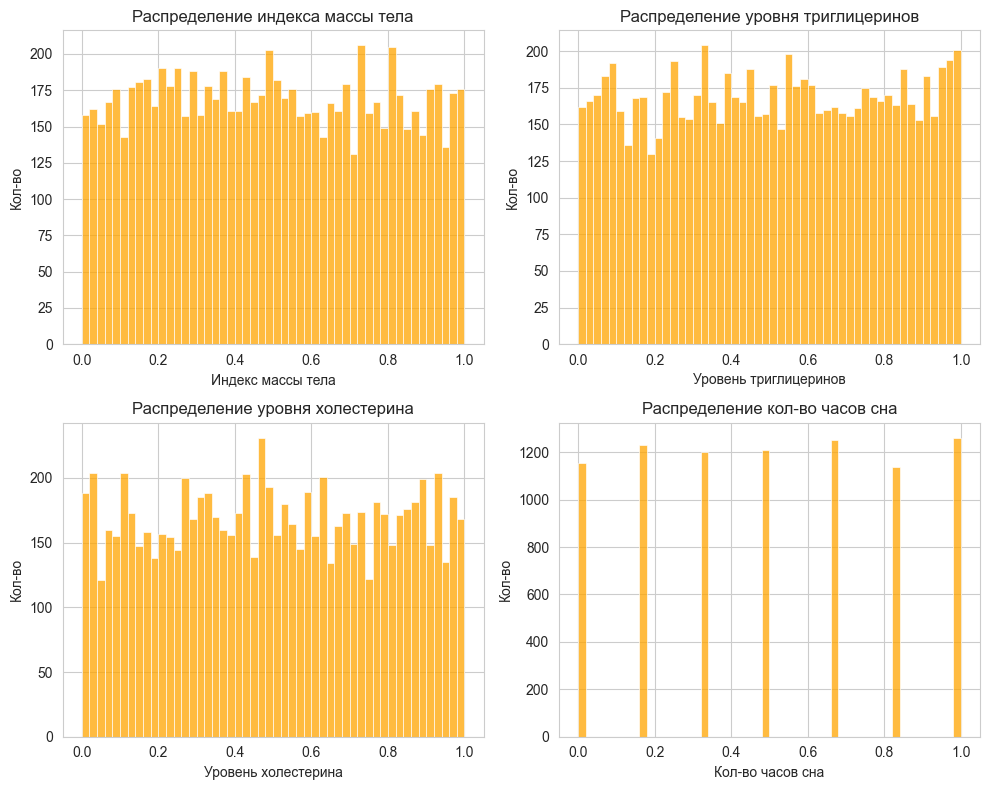

In [109]:
one_screen_hist(
    data=df_train,
    columns=['bmi', 'triglycerides','cholesterol', 'sleep_hours_per_day'],
    titles=['индекса массы тела', 'уровня триглицеринов', 'уровня холестерина', 'кол-во часов сна'],
    xlabels=['Индекс массы тела', 'Уровень триглицеринов', 'Уровень холестерина','Кол-во часов сна'],
    bins=50,
    color='orange',
    kde=False,
    title_prefix='Распределение '
)

**sleep_hours_per_day**

In [110]:
df_train.sleep_hours_per_day.value_counts()

sleep_hours_per_day
1.000000    1261
0.666667    1252
0.166667    1231
0.500000    1208
0.333333    1200
0.000000    1153
0.833333    1137
Name: count, dtype: int64

Судя по всему признак при заполнении носил категориальный характер , где значение 0 могло равняться "затрудняюсь ответить".

В любом случае заполнение нулевых значений медианой,средним или модой , создаст сильный дисбаланс. Поэтому эту переменную оставим как есть.

**bmi**

In [111]:
df_train[df_train.bmi == 0]

age  cholesterol  diabetes  family_history  smoking  \
5821  0.674157          0.7       0.0             1.0      1.0   

      alcohol_consumption  exercise_hours_per_week  diet  medication_use  \
5821                  0.0                 0.793327     0             0.0   

      stress_level  sedentary_hours_per_day   income  bmi  triglycerides  \
5821           9.0                  0.78101  0.49553  0.0       0.623377   

      sleep_hours_per_day  heart_attack_risk_(binary)  gender  \
5821             0.333333                         0.0  Female   

      systolic_blood_pressure  diastolic_blood_pressure   id  
5821                 0.329032                   0.72093  781

Видим что значение всего одно , заменим его средним значением.

In [112]:
df_train.bmi = df_train.bmi.replace(0.0, df_train.bmi.mean())

In [113]:
df_train.loc[5821]

age                           0.674157
cholesterol                        0.7
diabetes                           0.0
family_history                     1.0
smoking                            1.0
alcohol_consumption                0.0
exercise_hours_per_week       0.793327
diet                                 0
medication_use                     0.0
stress_level                       9.0
sedentary_hours_per_day        0.78101
income                         0.49553
bmi                           0.496831
triglycerides                 0.623377
sleep_hours_per_day           0.333333
heart_attack_risk_(binary)         0.0
gender                          Female
systolic_blood_pressure       0.329032
diastolic_blood_pressure       0.72093
id                                 781
Name: 5821, dtype: object

Видим что замена прошла удачно.

**triglycerides**

In [114]:
df_train[df_train.triglycerides == 0]

age  cholesterol  diabetes  family_history  smoking  \
352   0.629213     0.339286       0.0             1.0      1.0   
482   0.292135     0.803571       1.0             1.0      0.0   
719   0.258427     0.403571       0.0             1.0      1.0   
2431  0.415730     0.675000       1.0             1.0      1.0   
2539  0.404494     0.303571       1.0             0.0      1.0   
4277  0.674157     0.932143       1.0             1.0      1.0   
4852  0.056180     0.685714       1.0             0.0      1.0   
4902  0.719101     0.417857       1.0             0.0      1.0   
5909  0.550562     0.307143       1.0             0.0      1.0   
6011  0.842697     0.364286       0.0             0.0      1.0   
6571  0.438202     0.742857       1.0             0.0      1.0   
7275  0.730337     0.667857       1.0             0.0      1.0   
7341  0.258427     0.357143       1.0             0.0      1.0   
7457  0.629213     0.339286       0.0             1.0      1.0   
8100  0.808989     0.017857       0.0             1.0      1.0   

      alcohol_consumption  exercise_hours_per_week  diet  medication_use  \
352                   1.0                 0.267916     0             0.0   
482                   1.0                 0.189329     0             0.0   
719                   1.0                 0.321062     0             0.0   
2431                  1.0                 0.626515     0             1.0   
2539                  0.0                 0.980095     1             0.0   
4277                  0.0                 0.623003     1             1.0   
4852                  0.0                 0.115341     1             0.0   
4902                  0.0                 0.945414     1             1.0   
5909                  1.0                 0.319062     0             0.0   
6011                  1.0                 0.989380     0             1.0   
6571                  0.0                 0.569333     0             0.0   
7275                  1.0                 0.569633     2             1.0   
7341                  0.0                 0.211442     2             0.0   
7457                  1.0                 0.267916     0             0.0   
8100                  0.0                 0.219089     0             1.0   

      stress_level  sedentary_hours_per_day    income       bmi  \
352            6.0                 0.410936  0.931856  0.157660   
482            1.0                 0.356285  0.987845  0.349733   
719            3.0                 0.155785  0.210067  0.571239   
2431           8.0                 0.748416  0.101321  0.988834   
2539           6.0                 0.899554  0.026675  0.408826   
4277           8.0                 0.380862  0.586716  0.568544   
4852           7.0                 0.926586  0.228749  0.851009   
4902          10.0                 0.059760  0.412895  0.487231   
5909           8.0                 0.786829  0.014538  0.215975   
6011          10.0                 0.535280  0.947737  0.328601   
6571           1.0                 0.418422  0.546947  0.644721   
7275           8.0                 0.204056  0.578752  0.005483   
7341           6.0                 0.529538  0.245427  0.458152   
7457           6.0                 0.410936  0.931856  0.157660   
8100           9.0                 0.695949  0.788572  0.780623   

      triglycerides  sleep_hours_per_day  heart_attack_risk_(binary)  gender  \
352             0.0             0.000000                         0.0    Male   
482             0.0             0.166667                         1.0  Female   
719             0.0             0.666667                         0.0    Male   
2431            0.0             0.666667                         0.0    Male   
2539            0.0             0.333333                         0.0    Male   
4277            0.0             1.000000                         0.0    Male   
4852            0.0             0.333333                         0.0    Male   
4902            0.0     

In [115]:
df_train.triglycerides.describe()

count    8442.000000
mean        0.505539
std         0.290412
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64

Из за небольшого объема нулевых значений , заменим нули на среднее значение.

In [116]:
df_train.triglycerides = df_train.triglycerides.replace(0.0, df_train.triglycerides.mean())
df_train.triglycerides.describe()

count    8442.000000
mean        0.506437
std         0.289627
min         0.001299
25%         0.258442
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64

**cholesterol**

Выполним аналогичную **triglycerides** обработку.

In [117]:
df_train.cholesterol = df_train.cholesterol.replace(0.0, df_train.cholesterol.mean())
df_train.cholesterol.describe()

count    8442.000000
mean        0.502948
std         0.287178
min         0.003571
25%         0.264286
50%         0.500000
75%         0.750000
max         1.000000
Name: cholesterol, dtype: float64

In [118]:
(df_train.drop(bi, axis=1) == 0.0).sum()

age                            0
cholesterol                    0
exercise_hours_per_week        1
diet                        2783
stress_level                   0
sedentary_hours_per_day        1
income                         1
bmi                            0
triglycerides                  0
sleep_hours_per_day         1153
systolic_blood_pressure        0
diastolic_blood_pressure       0
id                             0
dtype: int64

In [119]:
df_train.columns

Index(['age', 'cholesterol', 'diabetes', 'family_history', 'smoking',
       'alcohol_consumption', 'exercise_hours_per_week', 'diet',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'sleep_hours_per_day',
       'heart_attack_risk_(binary)', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')

In [120]:
df_train.head(5)

age  cholesterol  diabetes  family_history  smoking  \
0  0.359551     0.732143       1.0             1.0      1.0   
1  0.202247     0.325000       1.0             1.0      0.0   
2  0.606742     0.860714       1.0             0.0      1.0   
3  0.730337     0.007143       0.0             0.0      1.0   
4  0.775281     0.757143       0.0             0.0      1.0   

   alcohol_consumption  exercise_hours_per_week  diet  medication_use  \
0                  1.0                 0.535505     1             0.0   
1                  1.0                 0.068690     2             0.0   
2                  1.0                 0.944001     2             1.0   
3                  1.0                 0.697023     0             1.0   
4                  1.0                 0.412878     1             0.0   

   stress_level  sedentary_hours_per_day    income       bmi  triglycerides  \
0           8.0                 0.225704  0.105948  0.459176       0.979221   
1           9.0                 0.289923  0.164217  0.117053       0.515584   
2           6.0                 0.550133  0.598745  0.373574       0.012987   
3           3.0                 0.330962  0.077605  0.049735       0.131169   
4           8.0                 0.524600  0.341960  0.830405       0.070130   

   sleep_hours_per_day  heart_attack_risk_(binary)  gender  \
0             0.333333                         0.0    Male   
1             0.833333                         0.0  Female   
2             1.000000                         0.0  Female   
3             0.333333                         1.0  Female   
4             1.000000                         1.0    Male   

   systolic_blood_pressure  diastolic_blood_pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047

#### Обработка категориальных признаков

Переведем значения признака *gender* из текстового описания в численное.

In [121]:
df_train['gender'] = df_train['gender'].map({'Male': '0', 'Female': '1'})
df_test['gender'] = df_test['gender'].map({'Male': '0', 'Female': '1'})
df_train['gender'].head(10)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: gender, dtype: object

Преобразуем типы данных категориальных переменных , для более удобной последующей обработки кодировщиком.

In [122]:
catcols = ['diabetes', 'family_history', 'smoking', 'alcohol_consumption', 'diet', 'stress_level', 'gender']

In [123]:
df_train[catcols] = df_train[catcols].astype('int').astype('category')
df_test[catcols] = df_test[catcols].astype('int').astype('category')

In [124]:
df_train.head(10)

age  cholesterol diabetes family_history smoking alcohol_consumption  \
0  0.359551     0.732143        1              1       1                   1   
1  0.202247     0.325000        1              1       0                   1   
2  0.606742     0.860714        1              0       1                   1   
3  0.730337     0.007143        0              0       1                   1   
4  0.775281     0.757143        0              0       1                   1   
5  0.168539     0.764286        0              1       1                   1   
6  0.483146     0.021429        1              0       1                   1   
7  0.235955     0.939286        1              0       1                   1   
8  0.685393     0.317857        0              0       1                   0   
9  0.213483     0.796429        1              1       1                   0   

   exercise_hours_per_week diet  medication_use stress_level  \
0                 0.535505    1             0.0            8   
1                 0.068690    2             0.0            9   
2                 0.944001    2             1.0            6   
3                 0.697023    0             1.0            3   
4                 0.412878    1             0.0            8   
5                 0.082682    1             0.0            7   
6                 0.540206    2             1.0            9   
7                 0.290837    2             1.0            7   
8                 0.803160    0             1.0            3   
9                 0.506971    1             0.0            7   

   sedentary_hours_per_day    income       bmi  triglycerides  \
0                 0.225704  0.105948  0.459176       0.979221   
1                 0.289923  0.164217  0.117053       0.515584   
2                 0.550133  0.598745  0.373574       0.012987   
3                 0.330962  0.077605  0.049735       0.131169   
4                 0.524600  0.341960  0.830405       0.070130   
5                 0.558262  0.640836  0.110571       0.238961   
6                 0.827611  0.774609  0.073718       0.072727   
7                 0.225275  0.999364  0.001534       0.180519   
8                 0.828176  0.142208  0.093073       0.990909   
9                 0.692973  0.820952  0.145447       0.171429   

   sleep_hours_per_day  heart_attack_risk_(binary) gender  \
0             0.333333                         0.0      0   
1             0.833333                         0.0      1   
2             1.000000                         0.0      1   
3             0.333333                         1.0      1   
4             1.000000                         1.0      0   
5             0.833333                         0.0      0   
6             0.000000                         1.0      0   
7             0.000000                         0.0      0   
8             0.166667                         1.0      0   
9             1.000000                         0.0      0   

   systolic_blood_pressure  diastolic_blood_pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047  
5                 0.464516                  0.418605  5817  
6                 0.361290                  0.569767  5580  
7                 0.690323                  0.639535  4963  
8                 0.664516                  0.616279  4521  
9                 0.651613                  0.720930  2455

### Вывод

- Мы удалили из обучающей и тестовой выборки неинформативные признаки такие как :  *unnamed:_0 , heart_rate, blood_sugar, ck_mb, troponin , obesity, physical_activity_days_per_week, previous_heart_problems*

- Так же нам удалось полностью избавится от пропусков и нулей в данных.

## Построение модели

Создадим выборки , применим параметр stratify , так как есть небольшой дисбаланс классов.

In [125]:
df_train['heart_attack_risk_(binary)'].value_counts()

heart_attack_risk_(binary)
0.0    5429
1.0    3013
Name: count, dtype: int64

In [126]:
X = df_train.drop(['id','heart_attack_risk_(binary)'], axis=1)
y = df_train['heart_attack_risk_(binary)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS, stratify=y) 
                                                
X_train.head(15)

age  cholesterol diabetes family_history smoking  \
8432  0.370787     0.603571        0              1       1   
3674  0.617978     0.025000        1              0       1   
7478  0.584270     0.567857        0              0       1   
7196  0.337079     0.782143        1              0       1   
6425  0.831461     0.707143        0              1       1   
2253  0.426966     0.039286        1              1       1   
5836  0.719101     0.353571        1              1       1   
7181  0.280899     0.250000        0              0       1   
548   0.460674     0.589286        1              1       1   
4169  0.067416     0.103571        1              0       0   
1505  0.449438     0.089286        1              0       1   
3080  0.235955     0.446429        1              1       1   
8264  0.426966     0.885714        1              1       1   
7748  0.359551     0.028571        0              1       1   
2004  0.853933     0.321429        1              0       1   

     alcohol_consumption  exercise_hours_per_week diet  medication_use  \
8432                   0                 0.457590    0             0.0   
3674                   0                 0.704990    1             1.0   
7478                   0                 0.534180    1             0.0   
7196                   1                 0.736298    1             0.0   
6425                   0                 0.977495    0             1.0   
2253                   1                 0.657615    2             1.0   
5836                   1                 0.049284    1             0.0   
7181                   1                 0.693901    0             1.0   
548                    0                 0.344682    0             0.0   
4169                   1                 0.543126    0             0.0   
1505                   0                 0.844483    1             0.0   
3080                   0                 0.083736    1             1.0   
8264                   1                 0.294890    0             1.0   
7748                   1                 0.994040    1             0.0   
2004                   0                 0.856227    2             0.0   

     stress_level  sedentary_hours_per_day    income       bmi  triglycerides  \
8432            2                 0.859525  0.515356  0.697038       0.771429   
3674            8                 0.461820  0.266778  0.034558       0.594805   
7478            3                 0.293034  0.241125  0.762636       0.588312   
7196            6                 0.646693  0.561113  0.154582       0.310390   
6425            2                 0.226457  0.151773  0.373017       0.738961   
2253            6                 0.002724  0.326676  0.334150       0.038961   
5836            7                 0.824743  0.918054  0.829053       0.628571   
7181            8                 0.366730  0.346502  0.774330       0.068831   
548             5                 0.252406  0.713940  0.530100       0.990909   
4169            2                 0.821653  0.817369  0.728569       0.822078   
1505            4                 0.048805  0.395463  0.350093       0.371429   
3080            3                 0.855700  0.546243  0.946246       0.962338   
8264            7                 0.484782  0.707080  0.188256       0.996104   
7748            3                 0.846280  0.678965  0.322243       0.096104   
2004            7                 0.766529  0.925646  0.873807       0.192208   

      sleep_hours_per_day gender  systolic_blood_pressure  \
8432             0.833333      0                 0.522581   
3674             0.833333      0                 0.206452   
7478             0.833333      1                 0.393548   
7196             0.666667      1                 0.722581   
6425             0.666667      0                 0.245161   
2253             0.333333      0                 0.683871   
5836             0.166667      0                 0.735484   
7181             0.000000      0

Разделим признаки для последующей передачи в пайплайн.

In [127]:
num_cols = ['stress_level']
cat_cols = ['diabetes', 'family_history', 'smoking', 'alcohol_consumption', 'diet', 'medication_use', 'gender']
remainder = X.columns.difference(num_cols + cat_cols).tolist()
remainder

['age',
 'bmi',
 'cholesterol',
 'diastolic_blood_pressure',
 'exercise_hours_per_week',
 'income',
 'sedentary_hours_per_day',
 'sleep_hours_per_day',
 'systolic_blood_pressure',
 'triglycerides']

In [128]:
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  
])

numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler())  
])

# remainder_transformer = Pipeline([
#     ('remainder', 'passthrough')
# ])
# Общий препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),      
        ('num', numeric_transformer, num_cols),
        ],
    remainder='passthrough',
    transformer_weights=None
)

In [129]:
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=RS),
        'params': {
            'classifier__max_depth': [3, 5, 7, 9, 11, None],
            'classifier__min_samples_split': [2, 3, 5, 7, 10],
            'classifier__min_samples_leaf': [1, 2, 3, 5],
            'classifier__max_features': ['sqrt', 'log2', None],
            'classifier__criterion': ['gini', 'entropy']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RS),
        'params': {
            'classifier__penalty': ['l1'],
                'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'classifier__solver': ['liblinear', 'saga'],
                'classifier__l1_ratio': [None]
        }
    },
    'SVC': {
        'model': SVC(random_state=RS, probability=False),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto'],
            
            
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9, 11, 15],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'classifier__leaf_size': [10, 20, 30, 50],
            'classifier__p': [1, 2]  
        }
    },
    
    
}

Учитывая находящийся на грани дисбаланс классов , в качестве метрики будем использовать **roc_auc**

In [130]:
%%time
# KNN выдавал предупреждение разных версий
warnings.filterwarnings("ignore", category=FutureWarning) 
results = {}
for name, config in models.items():

    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # Перебор по GridSearch
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_
         }
    
    print(f"{name} completed. Best Score: {grid.best_score_:.4f}")
for name, res in results.items():
    print(f"{name}:")
    print(f"Test Score: {res['best_score']:.4f}\n")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
DecisionTree completed. Best Score: 0.5464
Fitting 5 folds for each of 12 candidates, totalling 60 fits
LogisticRegression completed. Best Score: 0.5039
Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC completed. Best Score: 0.5308
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
KNeighborsClassifier completed. Best Score: 0.5763
DecisionTree:
Test Score: 0.5464

LogisticRegression:
Test Score: 0.5039

SVC:
Test Score: 0.5308

KNeighborsClassifier:
Test Score: 0.5763

CPU times: total: 18.3 s
Wall time: 1min 1s


Сохраним модель.

In [131]:
best_model = results['KNeighborsClassifier']['best_model']
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['diabetes', 'family_history',
                                                   'smoking',
                                                   'alcohol_consumption',
                                                   'diet', 'medication_use',
                                                   'gender']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['stress_level'])])),
                ('classifier',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=15, p=1,
                                      weights='distance'))])

Получим значимость каждого признака.

Так как **shap** плохо работает с **kNN** используем **permutation**

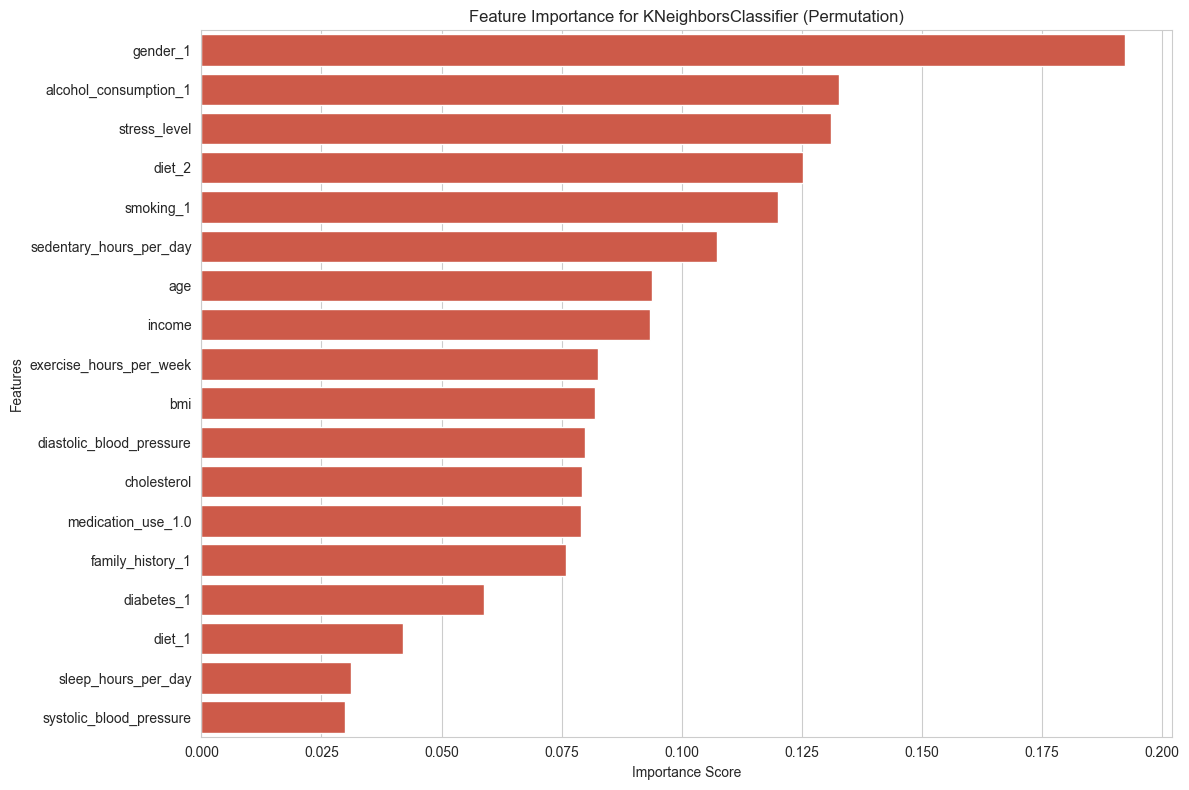

In [132]:
preprocessor = best_model['preprocessor']

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']  
cat_features = cat_encoder.get_feature_names_out(cat_cols)

feature_names = np.concatenate([cat_features, num_cols, remainder])

perm = permutation_importance(
    best_model,
    X_train,
    y_train,
    n_repeats=10,
    random_state=RS,
    n_jobs=-1
)


sorted_idx = perm.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=perm.importances_mean[sorted_idx], y=feature_names[sorted_idx])
plt.title("Feature Importance for KNeighborsClassifier (Permutation)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Видим что основными факторами риска выступают : **gender, stress_level, alcohol_consumption, smoking , diet**

Проверим нашу модель на тестовой выборке.

In [133]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Метрика roc_auc на тестовой выборке : {roc_auc.__round__(2)}')

Метрика roc_auc на тестовой выборке : 0.58


### Вывод

- Мы построили пайнлайн и протестировали 4 модели (DecisionTree, LogisticRegression, SVC, KNeighborsClassifier) , самый лучший результат оказался у **kNN** ее мы и выбрали для интеграции в сервис.

- В ходе анализа участвующих в обучение признаков , удалось установить что больше всего влияние на риск сердечно сосудистых проблем оказывают : **gender, stress_level, alcohol_consumption , smoking , sleep_hours_per_day**


## Общий вывод.

Нашей основной задачей было построение и последующие внедрении модели МО для предсказания проблем с сердцем , вот что нам удалось сделать по ходу выполнения:

- Мы загрузили и первично ознакомились с присланными нами данными. Создали два датасета **df_train и df_test** с обучающей и тестовой выборкой. В ходе первичного анализа удалось установить что часть присланных данных уже была нормализованна MinMaxSclar'om , а часть находится в *сыром* виде.

- Так для отбора признаков для модели мы провели анализ открытых медицинских источников с целью установить приоритетность представленных данных. На этом этапе более приоритетными для обучения показались следующие признаки : **troponin, ck_mb, systolic_blood_pressure, diastolic_blood_pressure , age, gender, cholesterol, diabetes, bmi, obesity, blood_sugar, triglycerides , family_history, smoking.**

- Корреляционный анализ показал низкую зависимость *таргета* c представленными признаками , что указывает на низкое качество данных , что в последующем отразится на качестве модели.

- Мы провели более подробный анализ представленных данных. И обнаружили большое количество аномалий, так нам пришлось полностью удалить из за нарушения структуры данных следующие признаки : **heart_rate, blood_sugar, ck_mb, troponin**. Так же мы избавились от признака **unnamed:_0** который полностью дублировал индексацию pandas. Мы обработали аномальные значения в признаке *gender* удалив *1 и 0* и тем самым заодно решили проблему пропусков в датасетах. На этом же этапе мы обработали категориальные признаки для последующей кодировки и передачи их в пайплайн. В итоге для обучения модели остались следующие признаки : **diet, medication_use, stress_level, sedentary_hours_per_day, income, bmi , triglycerides. 
sleep_hours_per_day, gender, systolic_blood_pressure, diastolic_blood_pressure.**


- На этапе построения модели мы использовали метод *pipeline* для поэтапного тестирования нескольких моделей с перебором гиперпараметров. Лучший результат показала модель *kNN* с оценкой **0.58** по метрике *roc_auc*. Из за качества данных результат не очень высокий.

- В блоке сохранения моделей и предсказаний мы сохранили результаты нашей работы для последующей реализации через фреймворк *FastApi*.

## Блок сохранения предсказаний и модели.

In [134]:
# joblib.dump(best_model, 'knn_model.pkl')

In [135]:
# pred = best_model.predict(df_test)
# pred = pd.DataFrame(pred)
# pred

In [136]:
# pred_id = df_test['id'].reset_index(drop=True)
# pred_id
# pred_csv = pd.concat([pred_id, pred], axis=1)
# pred_csv.columns=('id', 'pred')
# pred_csv[['id', 'pred']] = pred_csv[['id', 'pred']].astype(int)
# pred_csv.head(30)

In [137]:
# pred_csv.to_csv('predictions.csv', index=False) 

In [138]:
# pd.read_csv('predictions.csv')

In [139]:
# df_test = df_test.drop(['id'], axis=1)

In [140]:
# df_test.to_csv('test.csv', index=False) 